# DQN Training for Fire-Rescue Environment

#### Deep Q-Network - Value-Based Reinforcement Learning
 
This notebook includes:
 - 10+ hyperparameter configurations
 - Training with different settings
 - Logging and visualization
 - Model saving and evaluation

In [1]:
!pip install gymnasium stable-baselines3 tensorboard matplotlib pandas seaborn tqdm

In [2]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 2: Import Libraries
# ═══════════════════════════════════════════════════════════════════════
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Stable Baselines
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Add project root to path
project_root = Path.cwd().parent if 'training' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

# Import custom environment
from environment.custom_env import FireRescueEnv

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

print("✓ All libraries imported successfully")
print(f"✓ Project root: {project_root}")

✓ All libraries imported successfully
✓ Project root: c:\Users\HP\Programming\ML\fire_rescue_agent


In [3]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 3: Setup Directories
# ═══════════════════════════════════════════════════════════════════════
"""
Create necessary directories for models and logs
"""
# Create directory structure
base_dir = project_root / "models" / "dqn"
logs_dir = base_dir / "training_logs"
tensorboard_dir = base_dir / "tensorboard"
results_dir = project_root / "results"
plots_dir = results_dir / "plots"

for directory in [base_dir, logs_dir, tensorboard_dir, results_dir, plots_dir]:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Directories created:")
print(f"  - Models: {base_dir}")
print(f"  - Logs: {logs_dir}")
print(f"  - Tensorboard: {tensorboard_dir}")
print(f"  - Results: {results_dir}")

✓ Directories created:
  - Models: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn
  - Logs: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\training_logs
  - Tensorboard: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard
  - Results: c:\Users\HP\Programming\ML\fire_rescue_agent\results


In [4]:
# ═══════════════════════════════════════════════════════════════════════
# cell 4: DQN HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
Focused on key hyperparameters mentioned by instructor:
- learning_rate (lr)
- gamma (discount factor)
- batch_size
- epsilon_start (exploration_initial_eps)
- epsilon_end (exploration_final_eps)
- epsilon_decay (exploration_fraction)

Standardized across all configs:
- buffer_size = 50000 (same for all)
- learning_starts = 1000 (same for all)
- tau = 1.0 (hard target network updates)

Network architecture (policy_kwargs):
- Most use [64, 64] (standard)
- Some use [128, 128] (deeper) or [32, 32] (shallower)
"""

DQN_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE (Good starting point)
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized parameters
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard settings"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE (Too aggressive - may not converge)
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,  # Very high
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - Unstable learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE (Too slow - won't learn much)
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,  # Very low
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Slow learning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LARGE BATCH (More stable but slower)
    # ─────────────────────────────────────────────────────────────────────
    "config_4_large_batch": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 128,  # Large batch
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Large Batch - Stable gradients"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: SMALL BATCH (Noisier but faster)
    # ─────────────────────────────────────────────────────────────────────
    "config_5_small_batch": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 16,  # Small batch
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Small Batch - Fast updates"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW GAMMA (Short-sighted - doesn't plan ahead)
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.95,  # Low discount factor
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Myopic policy"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: HIGH GAMMA (Very forward-looking)
    # ─────────────────────────────────────────────────────────────────────
    "config_7_high_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.995,  # High discount factor
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.05,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Gamma - Long-term planning"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: FAST EXPLORATION DECAY (Stops exploring too soon)
    # ─────────────────────────────────────────────────────────────────────
    "config_8_fast_decay": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.1,  # Higher final epsilon
        "exploration_fraction": 0.1,  # Fast decay
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Fast Decay - Premature exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: SLOW EXPLORATION DECAY (Explores longer)
    # ─────────────────────────────────────────────────────────────────────
    "config_9_slow_decay": {
        "learning_rate": 1e-3,
        "gamma": 0.99,
        "batch_size": 32,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.01,  # Very low final epsilon
        "exploration_fraction": 0.4,  # Slow decay
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Slow Decay - Extended exploration"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: OPTIMIZED (Best guess based on task)
    # ─────────────────────────────────────────────────────────────────────
    "config_10_optimized": {
        "learning_rate": 3e-4,  # Sweet spot
        "gamma": 0.99,
        "batch_size": 64,  # Good balance
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.02,
        "exploration_fraction": 0.3,  # Balanced exploration
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[128, 128]),  # Deeper network
        "description": "Optimized - Well-balanced settings"
    },
    
     # ─────────────────────────────────────────────────────────────────────
    # Config 11: Zero epsilon start and end
    # ─────────────────────────────────────────────────────────────────────
    "config_11_low_gamma": {
        "learning_rate": 1e-3,
        "gamma": 0.95,
        "batch_size": 32,
        "exploration_initial_eps": 0,
        "exploration_final_eps": 0,
        "exploration_fraction": 0.2,
        # Standardized
        "buffer_size": 50000,
        "learning_starts": 1000,
        "tau": 1.0,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Zero Epsilon - No exploration"
    }
}

# ═══════════════════════════════════════════════════════════════════════
# CONFIGURATION SUMMARY TABLE
# ═══════════════════════════════════════════════════════════════════════
print(f"✓ Defined {len(DQN_CONFIGS)} DQN configurations\n")
print("=" * 100)
print(f"{'Config':<25} {'LR':<10} {'Gamma':<8} {'Batch':<8} {'ε_start':<10} {'ε_end':<10} {'ε_decay':<10} {'Network':<15}")
print("=" * 100)

for config_name, config in DQN_CONFIGS.items():
    net_arch = str(config['policy_kwargs']['net_arch'])
    print(f"{config_name:<25} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['batch_size']:<8} {config['exploration_initial_eps']:<10.2f} "
          f"{config['exploration_final_eps']:<10.2f} {config['exploration_fraction']:<10.2f} {net_arch:<15}")

print("=" * 100)
print("\nKey Insights:")
print("  • Configs 2 & 3: Test extreme learning rates")
print("  • Configs 4 & 5: Test batch size impact")
print("  • Configs 6 & 7: Test discount factor (short vs long-term)")
print("  • Configs 8 & 9: Test exploration strategy")
print("  • Config 10: Optimized combination")
print("\nAll configs use:")
print("  • buffer_size = 50,000 (standardized)")
print("  • learning_starts = 1,000 (standardized)")
print("  • tau = 1.0 (hard target updates)")
print("=" * 100)

✓ Defined 11 DQN configurations

Config                    LR         Gamma    Batch    ε_start    ε_end      ε_decay    Network        
config_1_baseline         1e-03      0.990    32       1.00       0.05       0.20       [64, 64]       
config_2_high_lr          5e-03      0.990    32       1.00       0.05       0.20       [64, 64]       
config_3_low_lr           1e-05      0.990    32       1.00       0.05       0.20       [64, 64]       
config_4_large_batch      1e-03      0.990    128      1.00       0.05       0.20       [64, 64]       
config_5_small_batch      1e-03      0.990    16       1.00       0.05       0.20       [64, 64]       
config_6_low_gamma        1e-03      0.950    32       1.00       0.05       0.20       [64, 64]       
config_7_high_gamma       1e-03      0.995    32       1.00       0.05       0.20       [64, 64]       
config_8_fast_decay       1e-03      0.990    32       1.00       0.10       0.10       [64, 64]       
config_9_slow_decay       1e-03

In [5]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 5: Training Configuration
# ═══════════════════════════════════════════════════════════════════════
"""
Set training parameters
"""
# Training settings
TOTAL_TIMESTEPS = 150000  # Total training steps per configuration
EVAL_FREQ = 5000          # Evaluate every N steps
N_EVAL_EPISODES = 10      # Number of episodes for evaluation
SAVE_FREQ = 10000         # Save model checkpoint every N steps

print("Training Configuration:")
print(f"  - Total Timesteps: {TOTAL_TIMESTEPS:,}")
print(f"  - Evaluation Frequency: {EVAL_FREQ:,}")
print(f"  - Evaluation Episodes: {N_EVAL_EPISODES}")
print(f"  - Checkpoint Frequency: {SAVE_FREQ:,}")

Training Configuration:
  - Total Timesteps: 150,000
  - Evaluation Frequency: 5,000
  - Evaluation Episodes: 10
  - Checkpoint Frequency: 10,000


In [6]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 6: Training Function
# ═══════════════════════════════════════════════════════════════════════
"""
Function to train a single DQN configuration
"""

def train_dqn_config(config_name, config, total_timesteps=TOTAL_TIMESTEPS):
    """
    Train DQN with given configuration
    
    Args:
        config_name: Name of the configuration
        config: Dictionary of hyperparameters
        total_timesteps: Total training steps
    
    Returns:
        Dictionary with training results
    """
    print(f"\n{'='*70}")
    print(f"Training: {config_name}")
    print(f"Description: {config['description']}")
    print(f"{'='*70}")
    
    # Create environment
    env = FireRescueEnv(grid_size=10, max_time=180)
    env = Monitor(env)
    
    # Create eval environment
    eval_env = FireRescueEnv(grid_size=10, max_time=180)
    eval_env = Monitor(eval_env)
    
    # Create model directory for this config
    model_dir = base_dir / config_name
    model_dir.mkdir(exist_ok=True)
    
    # Setup callbacks
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=str(model_dir),
        log_path=str(logs_dir / config_name),
        eval_freq=EVAL_FREQ,
        n_eval_episodes=N_EVAL_EPISODES,
        deterministic=True,
        render=False,
        verbose=1
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ,
        save_path=str(model_dir / "checkpoints"),
        name_prefix="dqn_checkpoint",
        save_replay_buffer=True,
        save_vecnormalize=True
    )
    
    callback_list = CallbackList([eval_callback, checkpoint_callback])
    
    # Extract hyperparameters (remove description)
    train_config = {k: v for k, v in config.items() if k != 'description'}
    
    # Create DQN model
    model = DQN(
        "MlpPolicy",
        env,
        verbose=1,
        seed=SEED,
        tensorboard_log=str(tensorboard_dir / config_name),
        **train_config
    )
    
    # Train
    start_time = datetime.now()
    print(f"\nStarting training at {start_time.strftime('%H:%M:%S')}")
    
    try:
        model.learn(
            total_timesteps=total_timesteps,
            callback=callback_list,
            progress_bar=True
        )
        
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"\n✓ Training completed in {training_time:.1f} seconds")
        
        # Save final model
        final_model_path = model_dir / "final_model"
        model.save(str(final_model_path))
        print(f"✓ Model saved to {final_model_path}")
        
        # Evaluate final model
        print("\nEvaluating final model...")
        mean_reward, std_reward = evaluate_policy(
            model, 
            eval_env, 
            n_eval_episodes=20,
            deterministic=True
        )
        
        print(f"✓ Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
        
        # Calculate success rate
        success_count = 0
        episode_rewards = []
        episode_lengths = []
        
        for _ in range(20):
            obs, info = eval_env.reset()
            episode_reward = 0
            episode_length = 0
            done = False
            
            while not done:
                action, _states = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = eval_env.step(action)
                done = terminated or truncated
                episode_reward += reward
                episode_length += 1
            
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            
            if info.get('success', False):
                success_count += 1
        
        success_rate = success_count / 20
        
        # Store results
        results = {
            'config_name': config_name,
            'description': config['description'],
            'mean_reward': mean_reward,
            'std_reward': std_reward,
            'success_rate': success_rate,
            'mean_episode_length': np.mean(episode_lengths),
            'std_episode_length': np.std(episode_lengths),
            'training_time': training_time,
            'total_timesteps': total_timesteps,
            'hyperparameters': train_config
        }
        
        # Save results to JSON
        results_file = model_dir / "results.json"
        with open(results_file, 'w') as f:
            # Convert numpy types to Python types for JSON
            json_results = {k: (float(v) if isinstance(v, (np.floating, np.integer)) else v) 
                          for k, v in results.items() if k != 'hyperparameters'}
            json_results['hyperparameters'] = {
                k: (float(v) if isinstance(v, (np.floating, np.integer)) else v)
                for k, v in results['hyperparameters'].items() if k != 'policy_kwargs'
            }
            json.dump(json_results, f, indent=4)
        
        print(f"✓ Results saved to {results_file}")
        
        # Cleanup
        env.close()
        eval_env.close()
        
        return results
        
    except Exception as e:
        print(f"\n✗ Training failed: {e}")
        env.close()
        eval_env.close()
        return None

print("✓ Training function defined")

✓ Training function defined


In [7]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 7: Train All Configurations
# ═══════════════════════════════════════════════════════════════════════
"""
Train all DQN configurations
WARNING: This will take several hours!
"""

# Store all results
all_results = []

print(f"\n{'#'*70}")
print(f"STARTING FULL TRAINING RUN")
print(f"Training {len(DQN_CONFIGS)} configurations")
print(f"Estimated time: {len(DQN_CONFIGS) * 15} - {len(DQN_CONFIGS) * 30} minutes")
print(f"{'#'*70}\n")

# Train each configuration
for config_name, config in DQN_CONFIGS.items():
    results = train_dqn_config(config_name, config)
    
    if results:
        all_results.append(results)
        print(f"\n✓ Completed {len(all_results)}/{len(DQN_CONFIGS)} configurations")
    else:
        print(f"\n✗ Failed configuration: {config_name}")
    
    print(f"\n{'='*70}\n")

print(f"\n{'#'*70}")
print(f"TRAINING COMPLETE!")
print(f"Successfully trained: {len(all_results)}/{len(DQN_CONFIGS)} configurations")
print(f"{'#'*70}")


######################################################################
STARTING FULL TRAINING RUN
Training 11 configurations
Estimated time: 165 - 330 minutes
######################################################################


Training: config_1_baseline
Description: Baseline - Standard settings
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 10:49:07
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_1_baseline\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10933    |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean     

Eval num_timesteps=5000, episode_reward=-23.19 +/- 127.31

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | -23.2    |
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.133    |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 10       |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 1383     |
|    time_elapsed     | 3        |
|    total_timesteps  | 5033     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0642   |
|    n_updates        | 1008     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 14.4     |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 1363     |
|    time_elapsed     | 4        |
|    total_timesteps  | 5701     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0484   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-19.99 +/- 122.44

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | -20      |
| rollout/            |          |
|    exploration_rate | 0.683    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0504   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | 34.4     |
|    exploration_rate | 0.675    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 1281     |
|    time_elapsed     | 8        |
|    total_timesteps  | 10261    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.59     |
|    n_updates        | 2315     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | 37.9     |
|    exploration_rate | 0.656    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 1284     |
|    time_elapsed     | 8        |
|    total_timesteps  | 10864    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.075    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=328.86 +/- 14.84

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 329      |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.138    |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | 61.4     |
|    exploration_rate | 0.51     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1233     |
|    time_elapsed     | 12       |
|    total_timesteps  | 15476    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.073    |
|    n_updates        | 3618     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | 67.8     |
|    exploration_rate | 0.49     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 1231     |
|    time_elapsed     | 13       |
|    total_timesteps  | 16105    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.145    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=234.61 +/- 207.24

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 235      |
| rollout/            |          |
|    exploration_rate | 0.367    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0638   |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 142      |
|    ep_rew_mean      | 114      |
|    exploration_rate | 0.348    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 1195     |
|    time_elapsed     | 17       |
|    total_timesteps  | 20575    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.473    |
|    n_updates        | 4893     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=182.11 +/- 237.38

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 182      |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.191    |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 146      |
|    ep_rew_mean      | 164      |
|    exploration_rate | 0.193    |
| time/               |          |
|    episodes         | 168      |
|    fps              | 1176     |
|    time_elapsed     | 21       |
|    total_timesteps  | 25472    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.408    |
|    n_updates        | 6117     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=53.21 +/- 236.45

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 53.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.582    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | 206      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 1165     |
|    time_elapsed     | 25       |
|    total_timesteps  | 30199    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.446    |
|    n_updates        | 7299     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=208.01 +/- 206.05

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 208      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.131    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | 234      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 224      |
|    fps              | 1149     |
|    time_elapsed     | 30       |
|    total_timesteps  | 35239    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.15     |
|    n_updates        | 8559     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=211.01 +/- 131.22

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 211      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.101    |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | 254      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 1140     |
|    time_elapsed     | 35       |
|    total_timesteps  | 40211    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.147    |
|    n_updates        | 9802     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=252.31 +/- 115.74

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 252      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0586   |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 235      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 1133     |
|    time_elapsed     | 39       |
|    total_timesteps  | 45096    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.283    |
|    n_updates        | 11023    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=292.31 +/- 94.27

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 292      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.58     |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 210      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 1124     |
|    time_elapsed     | 44       |
|    total_timesteps  | 50102    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.903    |
|    n_updates        | 12275    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=201.61 +/- 141.77

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 202      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0848   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 220      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 1120     |
|    time_elapsed     | 49       |
|    total_timesteps  | 55122    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.33     |
|    n_updates        | 13530    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=291.21 +/- 105.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0324   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 239      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 1115     |
|    time_elapsed     | 53       |
|    total_timesteps  | 60162    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.765    |
|    n_updates        | 14790    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=262.81 +/- 119.82

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 263      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0267   |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 1112     |
|    time_elapsed     | 58       |
|    total_timesteps  | 65161    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0675   |
|    n_updates        | 16040    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=248.66 +/- 165.88

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 249      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.118    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 277      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 420      |
|    fps              | 1112     |
|    time_elapsed     | 63       |
|    total_timesteps  | 70201    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.171    |
|    n_updates        | 17300    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=297.36 +/- 87.26

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 297      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.1      |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 269      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 448      |
|    fps              | 1111     |
|    time_elapsed     | 67       |
|    total_timesteps  | 75097    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.59     |
|    n_updates        | 18524    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=319.31 +/- 80.10

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 319      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0469   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 259      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 1111     |
|    time_elapsed     | 72       |
|    total_timesteps  | 80111    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.304    |
|    n_updates        | 19777    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=344.31 +/- 5.66

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 344      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0575   |
|    n_updates        | 20999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 255      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 504      |
|    fps              | 1108     |
|    time_elapsed     | 76       |
|    total_timesteps  | 85006    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0345   |
|    n_updates        | 21001    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 257      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 508      |
|    fps              | 1108     |
|    time_elapsed     | 77       |
|    total_timesteps  | 85726    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0918   |
|    n_updates      

Eval num_timesteps=90000, episode_reward=291.21 +/- 106.28

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.673    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 175      |
|    ep_rew_mean      | 268      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 1105     |
|    time_elapsed     | 81       |
|    total_timesteps  | 90590    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.207    |
|    n_updates        | 22397    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=342.01 +/- 4.24

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 342      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.583    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 286      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 564      |
|    fps              | 1103     |
|    time_elapsed     | 86       |
|    total_timesteps  | 95630    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0186   |
|    n_updates        | 23657    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=296.11 +/- 135.99

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 296      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.27     |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 298      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 592      |
|    fps              | 1102     |
|    time_elapsed     | 91       |
|    total_timesteps  | 100620   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.037    |
|    n_updates        | 24904    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=315.31 +/- 78.95

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 315      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.105    |
|    n_updates        | 25999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 306      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 620      |
|    fps              | 1102     |
|    time_elapsed     | 95       |
|    total_timesteps  | 105660   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0915   |
|    n_updates        | 26164    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=271.76 +/- 133.92

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 272      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0727   |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 301      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 1102     |
|    time_elapsed     | 100      |
|    total_timesteps  | 110617   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0552   |
|    n_updates        | 27404    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=342.51 +/- 5.60

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 343      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0388   |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 174      |
|    ep_rew_mean      | 301      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 676      |
|    fps              | 1102     |
|    time_elapsed     | 104      |
|    total_timesteps  | 115176   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.635    |
|    n_updates        | 28543    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=342.61 +/- 5.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 343      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0158   |
|    n_updates        | 29749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 302      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 704      |
|    fps              | 1102     |
|    time_elapsed     | 108      |
|    total_timesteps  | 120069   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0628   |
|    n_updates        | 29767    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=285.81 +/- 103.67

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 286      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.074    |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 302      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 736      |
|    fps              | 1097     |
|    time_elapsed     | 114      |
|    total_timesteps  | 125656   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0178   |
|    n_updates        | 31163    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=312.91 +/- 78.11

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 313      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.113    |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | 308      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 764      |
|    fps              | 1097     |
|    time_elapsed     | 118      |
|    total_timesteps  | 130523   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0355   |
|    n_updates        | 32380    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=181.91 +/- 222.53

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 182      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0176   |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | 304      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 792      |
|    fps              | 1096     |
|    time_elapsed     | 123      |
|    total_timesteps  | 135231   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0352   |
|    n_updates        | 33557    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=328.91 +/- 12.17

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 329      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0444   |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 298      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 820      |
|    fps              | 1093     |
|    time_elapsed     | 128      |
|    total_timesteps  | 140030   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.498    |
|    n_updates        | 34757    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=316.61 +/- 55.50

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 317      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0453   |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 297      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 848      |
|    fps              | 1093     |
|    time_elapsed     | 132      |
|    total_timesteps  | 145070   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.188    |
|    n_updates        | 36017    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=340.11 +/- 6.28

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0271   |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 137.2 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_1_baseline\final_model

Evaluating final model...
✓ Mean Reward: 337.06 ± 6.68
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_1_baseline\results.json

✓ Completed 1/11 configurations



Training: config_2_high_lr
Description: High LR - Unstable learning
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 10:51:26
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_2_high_lr\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 11680    |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
----------------------

Eval num_timesteps=5000, episode_reward=203.11 +/- 122.19

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 203      |
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0601   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 19.1     |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 1429     |
|    time_elapsed     | 3        |
|    total_timesteps  | 5485     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.292    |
|    n_updates        | 1121     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | 22.4     |
|    exploration_rate | 0.804    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 1421     |
|    time_elapsed     | 4        |
|    total_timesteps  | 6205     |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0634   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=338.11 +/- 2.17

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 338      |
| rollout/            |          |
|    exploration_rate | 0.683    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0229   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 44.1     |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 1307     |
|    time_elapsed     | 7        |
|    total_timesteps  | 10027    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.249    |
|    n_updates        | 2256     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | 46       |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 1307     |
|    time_elapsed     | 8        |
|    total_timesteps  | 10566    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.69     |
|    n_updates      

Eval num_timesteps=15000, episode_reward=129.21 +/- 251.52

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 129      |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0565   |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 158      |
|    ep_rew_mean      | 67.8     |
|    exploration_rate | 0.519    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 1258     |
|    time_elapsed     | 12       |
|    total_timesteps  | 15198    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.101    |
|    n_updates        | 3549     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=288.31 +/- 155.46

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 288      |
| rollout/            |          |
|    exploration_rate | 0.367    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.831    |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 126      |
|    ep_rew_mean      | 111      |
|    exploration_rate | 0.362    |
| time/               |          |
|    episodes         | 144      |
|    fps              | 1227     |
|    time_elapsed     | 16       |
|    total_timesteps  | 20142    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.123    |
|    n_updates        | 4785     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=239.71 +/- 208.81

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 240      |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.67     |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 104      |
|    ep_rew_mean      | 148      |
|    exploration_rate | 0.189    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 1199     |
|    time_elapsed     | 21       |
|    total_timesteps  | 25599    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.635    |
|    n_updates        | 6149     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=192.31 +/- 166.80

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 192      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.119    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 116      |
|    ep_rew_mean      | 187      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 1175     |
|    time_elapsed     | 25       |
|    total_timesteps  | 30459    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.915    |
|    n_updates        | 7364     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=245.01 +/- 182.64

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 245      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.233    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | 230      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 1161     |
|    time_elapsed     | 30       |
|    total_timesteps  | 35529    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0847   |
|    n_updates        | 8632     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=336.31 +/- 4.55

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 336      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.281    |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | 265      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 288      |
|    fps              | 1143     |
|    time_elapsed     | 35       |
|    total_timesteps  | 40569    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.242    |
|    n_updates        | 9892     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=297.41 +/- 115.13

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 297      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.322    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 259      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 316      |
|    fps              | 1108     |
|    time_elapsed     | 40       |
|    total_timesteps  | 45261    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.681    |
|    n_updates        | 11065    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=212.11 +/- 169.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 212      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0934   |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | 273      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 348      |
|    fps              | 1098     |
|    time_elapsed     | 46       |
|    total_timesteps  | 50689    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.913    |
|    n_updates        | 12422    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=127.91 +/- 135.56

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 128      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.27     |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 254      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 372      |
|    fps              | 1089     |
|    time_elapsed     | 50       |
|    total_timesteps  | 55009    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.462    |
|    n_updates        | 13502    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=155.71 +/- 118.83

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 156      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.141    |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 249      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 1077     |
|    time_elapsed     | 56       |
|    total_timesteps  | 60617    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.97     |
|    n_updates        | 14904    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=244.91 +/- 164.32

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 245      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.142    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 237      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 432      |
|    fps              | 1063     |
|    time_elapsed     | 61       |
|    total_timesteps  | 65657    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.823    |
|    n_updates        | 16164    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=246.86 +/- 161.56

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 247      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.183    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 237      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 460      |
|    fps              | 1061     |
|    time_elapsed     | 66       |
|    total_timesteps  | 70456    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.155    |
|    n_updates        | 17363    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=88.41 +/- 222.76

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 88.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.23     |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 233      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 488      |
|    fps              | 1058     |
|    time_elapsed     | 71       |
|    total_timesteps  | 75496    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.209    |
|    n_updates        | 18623    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=262.11 +/- 165.97

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 262      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.182    |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 247      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 516      |
|    fps              | 1056     |
|    time_elapsed     | 76       |
|    total_timesteps  | 80358    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.117    |
|    n_updates        | 19839    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=253.01 +/- 166.41

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 253      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.164    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 219      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 544      |
|    fps              | 1055     |
|    time_elapsed     | 80       |
|    total_timesteps  | 85130    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0811   |
|    n_updates        | 21032    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=310.71 +/- 77.90

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 311      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.13     |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 187      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 576      |
|    fps              | 1055     |
|    time_elapsed     | 85       |
|    total_timesteps  | 90405    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.33     |
|    n_updates        | 22351    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=340.11 +/- 6.28

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.0769   |
|    n_updates        | 23499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | 182      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 604      |
|    fps              | 1047     |
|    time_elapsed     | 91       |
|    total_timesteps  | 95445    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.15     |
|    n_updates        | 23611    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | 175      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 608      |
|    fps              | 1042     |
|    time_elapsed     | 92       |
|    total_timesteps  | 96165    |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.42     |
|    n_updates      

Eval num_timesteps=100000, episode_reward=31.56 +/- 135.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 31.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.137    |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 174      |
|    ep_rew_mean      | 180      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 632      |
|    fps              | 1003     |
|    time_elapsed     | 100      |
|    total_timesteps  | 100485   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.2      |
|    n_updates        | 24871    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=167.36 +/- 202.33

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 167      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.361    |
|    n_updates        | 25999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 196      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 660      |
|    fps              | 968      |
|    time_elapsed     | 108      |
|    total_timesteps  | 105525   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.07     |
|    n_updates        | 26131    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=337.71 +/- 7.49

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 338      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.233    |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 213      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 688      |
|    fps              | 932      |
|    time_elapsed     | 118      |
|    total_timesteps  | 110522   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.309    |
|    n_updates        | 27380    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=310.11 +/- 77.38

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 310      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.246    |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 201      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 716      |
|    fps              | 909      |
|    time_elapsed     | 127      |
|    total_timesteps  | 115562   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.12     |
|    n_updates        | 28640    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=111.11 +/- 186.57

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 111      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.118    |
|    n_updates        | 29749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 201      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 744      |
|    fps              | 888      |
|    time_elapsed     | 135      |
|    total_timesteps  | 120602   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.405    |
|    n_updates        | 29900    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=158.66 +/- 173.96

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 159      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.144    |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 198      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 868      |
|    time_elapsed     | 144      |
|    total_timesteps  | 125642   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.237    |
|    n_updates        | 31160    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=294.76 +/- 129.50

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 295      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.82     |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 196      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 800      |
|    fps              | 851      |
|    time_elapsed     | 153      |
|    total_timesteps  | 130682   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 3.37     |
|    n_updates        | 32420    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=264.31 +/- 159.08

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 264      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.109    |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 187      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 824      |
|    fps              | 834      |
|    time_elapsed     | 161      |
|    total_timesteps  | 135002   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 3.04     |
|    n_updates        | 33500    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=289.11 +/- 98.88

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 289      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 1.3      |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 183      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 852      |
|    fps              | 821      |
|    time_elapsed     | 170      |
|    total_timesteps  | 140042   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.609    |
|    n_updates        | 34760    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=158.06 +/- 189.76

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 158      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.295    |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 179      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 880      |
|    fps              | 809      |
|    time_elapsed     | 179      |
|    total_timesteps  | 145082   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.669    |
|    n_updates        | 36020    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=177.51 +/- 200.47

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 178      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.005    |
|    loss             | 0.216    |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 186.9 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_2_high_lr\final_model

Evaluating final model...
✓ Mean Reward: 119.01 ± 222.85
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_2_high_lr\results.json

✓ Completed 2/11 configurations



Training: config_3_low_lr
Description: Low LR - Slow learning
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 10:54:34
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_3_low_lr\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8890     |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
-----------------------------

Eval num_timesteps=5000, episode_reward=-83.09 +/- 133.07

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | -83.1    |
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.149    |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -9       |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 28       |
|    fps              | 921      |
|    time_elapsed     | 5        |
|    total_timesteps  | 5040     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.261    |
|    n_updates        | 1009     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -8.71    |
|    exploration_rate | 0.818    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 906      |
|    time_elapsed     | 6        |
|    total_timesteps  | 5760     |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.24     |
|    n_updates      

Eval num_timesteps=10000, episode_reward=-89.29 +/- 74.31

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | -89.3    |
| rollout/            |          |
|    exploration_rate | 0.683    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.196    |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -15.2    |
|    exploration_rate | 0.681    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 839      |
|    time_elapsed     | 12       |
|    total_timesteps  | 10080    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.254    |
|    n_updates        | 2269     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=66.21 +/- 18.91

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 66.2     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.22     |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -5.93    |
|    exploration_rate | 0.521    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 795      |
|    time_elapsed     | 19       |
|    total_timesteps  | 15120    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.239    |
|    n_updates        | 3529     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -4.24    |
|    exploration_rate | 0.498    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 793      |
|    time_elapsed     | 19       |
|    total_timesteps  | 15840    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.239    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=78.21 +/- 1.00

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 78.2     |
| rollout/            |          |
|    exploration_rate | 0.367    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.196    |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 5.83     |
|    exploration_rate | 0.362    |
| time/               |          |
|    episodes         | 112      |
|    fps              | 774      |
|    time_elapsed     | 26       |
|    total_timesteps  | 20160    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.196    |
|    n_updates        | 4789     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 8.12     |
|    exploration_rate | 0.339    |
| time/               |          |
|    episodes         | 116      |
|    fps              | 770      |
|    time_elapsed     | 27       |
|    total_timesteps  | 20880    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.52     |
|    n_updates      

Eval num_timesteps=25000, episode_reward=78.31 +/- 1.45

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 78.3     |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.173    |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 22.7     |
|    exploration_rate | 0.202    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 746      |
|    time_elapsed     | 33       |
|    total_timesteps  | 25200    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.178    |
|    n_updates        | 6049     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 26.1     |
|    exploration_rate | 0.179    |
| time/               |          |
|    episodes         | 144      |
|    fps              | 745      |
|    time_elapsed     | 34       |
|    total_timesteps  | 25920    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.16     |
|    n_updates      

Eval num_timesteps=30000, episode_reward=78.81 +/- 1.11

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 78.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.461    |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 46.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 168      |
|    fps              | 729      |
|    time_elapsed     | 41       |
|    total_timesteps  | 30240    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.175    |
|    n_updates        | 7309     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 48.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 172      |
|    fps              | 729      |
|    time_elapsed     | 42       |
|    total_timesteps  | 30960    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.307    |
|    n_updates      

Eval num_timesteps=35000, episode_reward=73.51 +/- 14.81

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 73.5     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.191    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 60       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 709      |
|    time_elapsed     | 49       |
|    total_timesteps  | 35280    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.146    |
|    n_updates        | 8569     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=24.11 +/- 84.48

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 24.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.503    |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 64.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 224      |
|    fps              | 700      |
|    time_elapsed     | 57       |
|    total_timesteps  | 40320    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.291    |
|    n_updates        | 9829     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=74.31 +/- 13.05

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 74.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.122    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 63       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 252      |
|    fps              | 692      |
|    time_elapsed     | 65       |
|    total_timesteps  | 45360    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.125    |
|    n_updates        | 11089    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=54.21 +/- 74.67

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 54.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.486    |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 53.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 682      |
|    time_elapsed     | 73       |
|    total_timesteps  | 50400    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.27     |
|    n_updates        | 12349    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=61.71 +/- 40.06

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 61.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.111    |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 43.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 674      |
|    time_elapsed     | 82       |
|    total_timesteps  | 55440    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.154    |
|    n_updates        | 13609    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=5.81 +/- 98.31

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 5.81     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.458    |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 45.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 656      |
|    time_elapsed     | 92       |
|    total_timesteps  | 60480    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.198    |
|    n_updates        | 14869    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=28.91 +/- 63.55

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 28.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.246    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 49.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 628      |
|    time_elapsed     | 104      |
|    total_timesteps  | 65520    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.145    |
|    n_updates        | 16129    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=38.31 +/- 86.57

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 38.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.119    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 49.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 604      |
|    time_elapsed     | 116      |
|    total_timesteps  | 70415    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.191    |
|    n_updates        | 17353    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=50.61 +/- 52.52

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 50.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.165    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 53.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 420      |
|    fps              | 597      |
|    time_elapsed     | 126      |
|    total_timesteps  | 75455    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.192    |
|    n_updates        | 18613    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=65.01 +/- 28.16

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 65       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.147    |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 55.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 448      |
|    fps              | 589      |
|    time_elapsed     | 136      |
|    total_timesteps  | 80495    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.136    |
|    n_updates        | 19873    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=79.01 +/- 0.98

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 79       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.485    |
|    n_updates        | 20999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 65.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 587      |
|    time_elapsed     | 145      |
|    total_timesteps  | 85535    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.203    |
|    n_updates        | 21133    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 66.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 480      |
|    fps              | 587      |
|    time_elapsed     | 146      |
|    total_timesteps  | 86255    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.188    |
|    n_updates      

Eval num_timesteps=90000, episode_reward=73.01 +/- 19.29

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 73       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.156    |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 70.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 504      |
|    fps              | 587      |
|    time_elapsed     | 154      |
|    total_timesteps  | 90575    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.102    |
|    n_updates        | 22393    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=53.91 +/- 75.91

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 53.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.509    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 67.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 588      |
|    time_elapsed     | 162      |
|    total_timesteps  | 95615    |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.138    |
|    n_updates        | 23653    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=35.91 +/- 87.69

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 35.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0864   |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 63.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 560      |
|    fps              | 591      |
|    time_elapsed     | 170      |
|    total_timesteps  | 100655   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0994   |
|    n_updates        | 24913    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=79.11 +/- 1.58

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 79.1     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0861   |
|    n_updates        | 25999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 59.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 588      |
|    fps              | 596      |
|    time_elapsed     | 177      |
|    total_timesteps  | 105695   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.137    |
|    n_updates        | 26173    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 59.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 592      |
|    fps              | 597      |
|    time_elapsed     | 178      |
|    total_timesteps  | 106415   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.12     |
|    n_updates      

Eval num_timesteps=110000, episode_reward=34.61 +/- 87.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 34.6     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.163    |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 52.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 612      |
|    fps              | 598      |
|    time_elapsed     | 183      |
|    total_timesteps  | 110015   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.226    |
|    n_updates        | 27253    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=79.01 +/- 0.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 79       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.497    |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 42.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 640      |
|    fps              | 599      |
|    time_elapsed     | 191      |
|    total_timesteps  | 115055   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.183    |
|    n_updates        | 28513    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=78.81 +/- 0.80

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 78.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.108    |
|    n_updates        | 29749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 44.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 668      |
|    fps              | 601      |
|    time_elapsed     | 199      |
|    total_timesteps  | 120095   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.175    |
|    n_updates        | 29773    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=53.81 +/- 75.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 53.8     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0836   |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 45.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 696      |
|    fps              | 600      |
|    time_elapsed     | 208      |
|    total_timesteps  | 125135   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.167    |
|    n_updates        | 31033    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=62.31 +/- 51.72

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 62.3     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.552    |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 53.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 724      |
|    fps              | 602      |
|    time_elapsed     | 216      |
|    total_timesteps  | 130175   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.144    |
|    n_updates        | 32293    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=3.11 +/- 118.45

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 3.11     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.109    |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 61.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 752      |
|    fps              | 603      |
|    time_elapsed     | 223      |
|    total_timesteps  | 135215   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.141    |
|    n_updates        | 33553    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=80.01 +/- 1.17

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 80       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.108    |
|    n_updates        | 34749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 66.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 780      |
|    fps              | 605      |
|    time_elapsed     | 231      |
|    total_timesteps  | 140255   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.154    |
|    n_updates        | 34813    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 66       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 784      |
|    fps              | 606      |
|    time_elapsed     | 232      |
|    total_timesteps  | 140975   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.109    |
|    n_updates      

Eval num_timesteps=145000, episode_reward=79.41 +/- 0.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 79.4     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0434   |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 66.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 808      |
|    fps              | 608      |
|    time_elapsed     | 238      |
|    total_timesteps  | 145295   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.074    |
|    n_updates        | 36073    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=78.91 +/- 1.55

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 78.9     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 1e-05    |
|    loss             | 0.0574   |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 245.2 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_3_low_lr\final_model

Evaluating final model...
✓ Mean Reward: 79.16 ± 1.12
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_3_low_lr\results.json

✓ Completed 3/11 configurations



Training: config_4_large_batch
Description: Large Batch - Stable gradients
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 10:58:41
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_4_large_batch\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 12166    |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
----------------

Eval num_timesteps=5000, episode_reward=39.41 +/- 64.68

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 39.4     |
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0999   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 13.5     |
|    exploration_rate | 0.82     |
| time/               |          |
|    episodes         | 32       |
|    fps              | 780      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5679     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0932   |
|    n_updates        | 1169     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 16       |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 793      |
|    time_elapsed     | 8        |
|    total_timesteps  | 6399     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.152    |
|    n_updates      

Eval num_timesteps=10000, episode_reward=240.31 +/- 195.96

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 240      |
| rollout/            |          |
|    exploration_rate | 0.683    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.218    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 37.6     |
|    exploration_rate | 0.662    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 734      |
|    time_elapsed     | 14       |
|    total_timesteps  | 10688    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.191    |
|    n_updates        | 2421     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 42       |
|    exploration_rate | 0.64     |
| time/               |          |
|    episodes         | 68       |
|    fps              | 752      |
|    time_elapsed     | 15       |
|    total_timesteps  | 11357    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.437    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=240.01 +/- 197.69

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 240      |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.325    |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 60.8     |
|    exploration_rate | 0.523    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 712      |
|    time_elapsed     | 21       |
|    total_timesteps  | 15048    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.545    |
|    n_updates        | 3511     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=259.91 +/- 164.96

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 260      |
| rollout/            |          |
|    exploration_rate | 0.367    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.596    |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | 106      |
|    exploration_rate | 0.351    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 720      |
|    time_elapsed     | 28       |
|    total_timesteps  | 20485    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.317    |
|    n_updates        | 4871     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | 114      |
|    exploration_rate | 0.334    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 721      |
|    time_elapsed     | 29       |
|    total_timesteps  | 21028    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.252    |
|    n_updates      

Eval num_timesteps=25000, episode_reward=334.71 +/- 3.91

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 335      |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.582    |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | 158      |
|    exploration_rate | 0.194    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 720      |
|    time_elapsed     | 35       |
|    total_timesteps  | 25452    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.127    |
|    n_updates        | 6112     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | 166      |
|    exploration_rate | 0.175    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 718      |
|    time_elapsed     | 36       |
|    total_timesteps  | 26068    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0993   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=286.41 +/- 154.83

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 286      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.434    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | 206      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 192      |
|    fps              | 688      |
|    time_elapsed     | 44       |
|    total_timesteps  | 30440    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.781    |
|    n_updates        | 7359     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=293.01 +/- 156.97

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 293      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0809   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | 252      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 220      |
|    fps              | 675      |
|    time_elapsed     | 52       |
|    total_timesteps  | 35476    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.117    |
|    n_updates        | 8618     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=259.01 +/- 110.51

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 259      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.483    |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 273      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 248      |
|    fps              | 662      |
|    time_elapsed     | 60       |
|    total_timesteps  | 40245    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.457    |
|    n_updates        | 9811     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=240.21 +/- 130.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 240      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.117    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 284      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 655      |
|    time_elapsed     | 69       |
|    total_timesteps  | 45285    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.138    |
|    n_updates        | 11071    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=321.21 +/- 80.73

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 321      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.25     |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 286      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 304      |
|    fps              | 653      |
|    time_elapsed     | 76       |
|    total_timesteps  | 50164    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.287    |
|    n_updates        | 12290    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=80.71 +/- 186.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 80.7     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.163    |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 284      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 332      |
|    fps              | 644      |
|    time_elapsed     | 85       |
|    total_timesteps  | 55172    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.13     |
|    n_updates        | 13542    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=344.61 +/- 4.15

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 345      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0666   |
|    n_updates        | 14749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 276      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 360      |
|    fps              | 645      |
|    time_elapsed     | 93       |
|    total_timesteps  | 60157    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.854    |
|    n_updates        | 14789    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 276      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 643      |
|    time_elapsed     | 94       |
|    total_timesteps  | 60877    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.27     |
|    n_updates      

Eval num_timesteps=65000, episode_reward=272.86 +/- 147.64

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 273      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.166    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 175      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 637      |
|    time_elapsed     | 102      |
|    total_timesteps  | 65521    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.128    |
|    n_updates        | 16130    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=289.71 +/- 105.33

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 290      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0504   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | 268      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 424      |
|    fps              | 636      |
|    time_elapsed     | 111      |
|    total_timesteps  | 70714    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.123    |
|    n_updates        | 17428    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=235.41 +/- 172.17

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 235      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.253    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 271      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 634      |
|    time_elapsed     | 118      |
|    total_timesteps  | 75422    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.059    |
|    n_updates        | 18605    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=181.16 +/- 215.65

Episode length: 145.20 +/- 69.60

----------------------------------
| eval/               |          |
|    mean_ep_length   | 145      |
|    mean_reward      | 181      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0621   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | 278      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 480      |
|    fps              | 635      |
|    time_elapsed     | 126      |
|    total_timesteps  | 80147    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.113    |
|    n_updates        | 19786    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=309.58 +/- 82.67

Episode length: 162.40 +/- 52.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 162      |
|    mean_reward      | 310      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.288    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 280      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 508      |
|    fps              | 637      |
|    time_elapsed     | 133      |
|    total_timesteps  | 85090    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0885   |
|    n_updates        | 21022    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=340.31 +/- 7.69

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0381   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | 290      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 540      |
|    fps              | 640      |
|    time_elapsed     | 141      |
|    total_timesteps  | 90411    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.521    |
|    n_updates        | 22352    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=107.48 +/- 247.79

Episode length: 162.60 +/- 52.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 163      |
|    mean_reward      | 107      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.182    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 172      |
|    ep_rew_mean      | 292      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 568      |
|    fps              | 636      |
|    time_elapsed     | 149      |
|    total_timesteps  | 95151    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0568   |
|    n_updates        | 23537    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=338.61 +/- 6.86

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 339      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.264    |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | 299      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 600      |
|    fps              | 637      |
|    time_elapsed     | 157      |
|    total_timesteps  | 100631   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.284    |
|    n_updates        | 24907    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=262.43 +/- 101.85

Episode length: 162.80 +/- 51.60

----------------------------------
| eval/               |          |
|    mean_ep_length   | 163      |
|    mean_reward      | 262      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.284    |
|    n_updates        | 25999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 290      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 628      |
|    fps              | 636      |
|    time_elapsed     | 165      |
|    total_timesteps  | 105172   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0631   |
|    n_updates        | 26042    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=292.81 +/- 155.58

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 293      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0265   |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 281      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 660      |
|    fps              | 637      |
|    time_elapsed     | 173      |
|    total_timesteps  | 110367   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.829    |
|    n_updates        | 27341    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=195.01 +/- 224.28

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 195      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0533   |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 163      |
|    ep_rew_mean      | 263      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 688      |
|    fps              | 636      |
|    time_elapsed     | 180      |
|    total_timesteps  | 115016   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.273    |
|    n_updates        | 28503    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=238.51 +/- 172.12

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 239      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.351    |
|    n_updates        | 29749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 720      |
|    fps              | 637      |
|    time_elapsed     | 189      |
|    total_timesteps  | 120587   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.187    |
|    n_updates        | 29896    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=285.03 +/- 100.44

Episode length: 147.80 +/- 64.53

----------------------------------
| eval/               |          |
|    mean_ep_length   | 148      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0622   |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 272      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 748      |
|    fps              | 633      |
|    time_elapsed     | 197      |
|    total_timesteps  | 125166   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0427   |
|    n_updates        | 31041    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=216.95 +/- 156.65

Episode length: 145.80 +/- 68.40

----------------------------------
| eval/               |          |
|    mean_ep_length   | 146      |
|    mean_reward      | 217      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0532   |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 273      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 780      |
|    fps              | 632      |
|    time_elapsed     | 206      |
|    total_timesteps  | 130267   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.349    |
|    n_updates        | 32316    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=292.71 +/- 141.60

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 293      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.692    |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 283      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 812      |
|    fps              | 631      |
|    time_elapsed     | 214      |
|    total_timesteps  | 135548   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.318    |
|    n_updates        | 33636    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=275.86 +/- 127.64

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 276      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0389   |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 274      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 633      |
|    time_elapsed     | 221      |
|    total_timesteps  | 140176   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.18     |
|    n_updates        | 34793    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=338.11 +/- 6.56

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 338      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.29     |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 269      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 876      |
|    fps              | 630      |
|    time_elapsed     | 230      |
|    total_timesteps  | 145564   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0122   |
|    n_updates        | 36140    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=339.71 +/- 5.85

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0592   |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 238.6 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_4_large_batch\final_model

Evaluating final model...
✓ Mean Reward: 276.29 ± 109.49
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_4_large_batch\results.json

✓ Completed 4/11 configurations



Training: config_5_small_batch
Description: Small Batch - Fast updates
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 11:02:41
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_5_small_batch\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 11737    |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
-------

Eval num_timesteps=5000, episode_reward=14.61 +/- 87.37

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 14.6     |
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.147    |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 174      |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 975      |
|    time_elapsed     | 5        |
|    total_timesteps  | 5565     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.16     |
|    n_updates        | 1141     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 174      |
|    ep_rew_mean      | 16.7     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 960      |
|    time_elapsed     | 6        |
|    total_timesteps  | 6254     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0874   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=50.41 +/- 77.48

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 50.4     |
| rollout/            |          |
|    exploration_rate | 0.683    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0966   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 28.8     |
|    exploration_rate | 0.676    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 884      |
|    time_elapsed     | 11       |
|    total_timesteps  | 10237    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.105    |
|    n_updates        | 2309     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.654    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 871      |
|    time_elapsed     | 12       |
|    total_timesteps  | 10915    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.175    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=86.21 +/- 164.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 86.2     |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0811   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 52.4     |
|    exploration_rate | 0.516    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 790      |
|    time_elapsed     | 19       |
|    total_timesteps  | 15285    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0553   |
|    n_updates        | 3571     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | 56       |
|    exploration_rate | 0.494    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 784      |
|    time_elapsed     | 20       |
|    total_timesteps  | 15967    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.156    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=237.21 +/- 188.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 237      |
| rollout/            |          |
|    exploration_rate | 0.367    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 3.19     |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | 95.1     |
|    exploration_rate | 0.353    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 763      |
|    time_elapsed     | 26       |
|    total_timesteps  | 20420    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.132    |
|    n_updates        | 4854     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | 100      |
|    exploration_rate | 0.334    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 761      |
|    time_elapsed     | 27       |
|    total_timesteps  | 21040    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.232    |
|    n_updates      

Eval num_timesteps=25000, episode_reward=286.51 +/- 156.14

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 287      |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0986   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | 142      |
|    exploration_rate | 0.202    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 755      |
|    time_elapsed     | 33       |
|    total_timesteps  | 25208    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.119    |
|    n_updates        | 6051     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | 149      |
|    exploration_rate | 0.179    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 754      |
|    time_elapsed     | 34       |
|    total_timesteps  | 25928    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.185    |
|    n_updates      

Eval num_timesteps=30000, episode_reward=335.71 +/- 3.83

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 336      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0524   |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 190      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 188      |
|    fps              | 730      |
|    time_elapsed     | 41       |
|    total_timesteps  | 30012    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.583    |
|    n_updates        | 7252     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | 198      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 192      |
|    fps              | 726      |
|    time_elapsed     | 42       |
|    total_timesteps  | 30732    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.471    |
|    n_updates      

Eval num_timesteps=35000, episode_reward=232.71 +/- 204.95

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 233      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0469   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | 241      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 710      |
|    time_elapsed     | 49       |
|    total_timesteps  | 35052    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.101    |
|    n_updates        | 8512     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=252.31 +/- 176.33

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 252      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.126    |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 259      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 244      |
|    fps              | 702      |
|    time_elapsed     | 57       |
|    total_timesteps  | 40092    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.375    |
|    n_updates        | 9772     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=232.81 +/- 205.83

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 233      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.265    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 269      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 694      |
|    time_elapsed     | 65       |
|    total_timesteps  | 45132    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.233    |
|    n_updates        | 11032    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=288.31 +/- 104.06

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 288      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.053    |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 269      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 300      |
|    fps              | 688      |
|    time_elapsed     | 72       |
|    total_timesteps  | 50172    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.155    |
|    n_updates        | 12292    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=289.01 +/- 104.98

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 289      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0697   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 260      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 679      |
|    time_elapsed     | 81       |
|    total_timesteps  | 55212    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.86     |
|    n_updates        | 13552    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=309.11 +/- 89.35

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 309      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0904   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 254      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 672      |
|    time_elapsed     | 89       |
|    total_timesteps  | 60252    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.18     |
|    n_updates        | 14812    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=259.11 +/- 119.21

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 259      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0366   |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 237      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 384      |
|    fps              | 669      |
|    time_elapsed     | 97       |
|    total_timesteps  | 65292    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0608   |
|    n_updates        | 16072    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=270.01 +/- 133.42

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 270      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0767   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 233      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 412      |
|    fps              | 662      |
|    time_elapsed     | 106      |
|    total_timesteps  | 70332    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0646   |
|    n_updates        | 17332    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=339.51 +/- 6.26

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.236    |
|    n_updates        | 18499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 238      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 440      |
|    fps              | 662      |
|    time_elapsed     | 113      |
|    total_timesteps  | 75372    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.78     |
|    n_updates        | 18592    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 246      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 662      |
|    time_elapsed     | 114      |
|    total_timesteps  | 76092    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.203    |
|    n_updates      

Eval num_timesteps=80000, episode_reward=185.11 +/- 128.73

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 185      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0147   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 256      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 468      |
|    fps              | 661      |
|    time_elapsed     | 121      |
|    total_timesteps  | 80412    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.275    |
|    n_updates        | 19852    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=208.11 +/- 146.72

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 208      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.126    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 265      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 496      |
|    fps              | 661      |
|    time_elapsed     | 129      |
|    total_timesteps  | 85452    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0795   |
|    n_updates        | 21112    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=316.81 +/- 79.37

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 317      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0126   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 263      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 524      |
|    fps              | 660      |
|    time_elapsed     | 136      |
|    total_timesteps  | 90492    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0439   |
|    n_updates        | 22372    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=290.71 +/- 105.60

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0558   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 275      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 552      |
|    fps              | 657      |
|    time_elapsed     | 145      |
|    total_timesteps  | 95532    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.182    |
|    n_updates        | 23632    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=314.61 +/- 78.58

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 315      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.164    |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 274      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 655      |
|    time_elapsed     | 153      |
|    total_timesteps  | 100572   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.436    |
|    n_updates        | 24892    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=340.01 +/- 3.37

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0246   |
|    n_updates        | 25999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 287      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 608      |
|    fps              | 656      |
|    time_elapsed     | 160      |
|    total_timesteps  | 105612   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0914   |
|    n_updates        | 26152    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 289      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 612      |
|    fps              | 656      |
|    time_elapsed     | 162      |
|    total_timesteps  | 106332   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.96     |
|    n_updates      

Eval num_timesteps=110000, episode_reward=290.91 +/- 105.99

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.231    |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 290      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 636      |
|    fps              | 652      |
|    time_elapsed     | 169      |
|    total_timesteps  | 110652   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.486    |
|    n_updates        | 27412    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=291.71 +/- 155.91

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 292      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.123    |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 292      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 664      |
|    fps              | 650      |
|    time_elapsed     | 177      |
|    total_timesteps  | 115692   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.269    |
|    n_updates        | 28672    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=290.41 +/- 105.67

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 290      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.149    |
|    n_updates        | 29749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 305      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 688      |
|    fps              | 650      |
|    time_elapsed     | 184      |
|    total_timesteps  | 120012   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.945    |
|    n_updates        | 29752    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=346.01 +/- 3.71

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 346      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.1      |
|    n_updates        | 30999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 300      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 716      |
|    fps              | 649      |
|    time_elapsed     | 192      |
|    total_timesteps  | 125052   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0753   |
|    n_updates        | 31012    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 301      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 720      |
|    fps              | 649      |
|    time_elapsed     | 193      |
|    total_timesteps  | 125772   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.201    |
|    n_updates      

Eval num_timesteps=130000, episode_reward=344.71 +/- 5.02

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 345      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.21     |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 302      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 744      |
|    fps              | 647      |
|    time_elapsed     | 200      |
|    total_timesteps  | 130092   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.142    |
|    n_updates        | 32272    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=292.81 +/- 83.18

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 293      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.258    |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 311      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 645      |
|    time_elapsed     | 209      |
|    total_timesteps  | 135132   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.32     |
|    n_updates        | 33532    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=293.51 +/- 155.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 294      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0188   |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 313      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 800      |
|    fps              | 644      |
|    time_elapsed     | 217      |
|    total_timesteps  | 140172   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0481   |
|    n_updates        | 34792    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=306.91 +/- 92.97

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 307      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.42     |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 315      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 828      |
|    fps              | 644      |
|    time_elapsed     | 225      |
|    total_timesteps  | 145190   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0222   |
|    n_updates        | 36047    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=314.51 +/- 74.28

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 315      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0157   |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 233.0 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_5_small_batch\final_model

Evaluating final model...
✓ Mean Reward: 334.71 ± 20.21
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_5_small_batch\results.json

✓ Completed 5/11 configurations



Training: config_6_low_gamma
Description: Low Gamma - Myopic policy
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 11:06:35
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_6_low_gamma\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10848    |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
-------------

Eval num_timesteps=5000, episode_reward=-20.79 +/- 124.21

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | -20.8    |
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0946   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 715      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5030     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0365   |
|    n_updates        | 1007     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0.82     |
| time/               |          |
|    episodes         | 32       |
|    fps              | 723      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5681     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.146    |
|    n_updates      

Eval num_timesteps=10000, episode_reward=55.11 +/- 129.54

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 55.1     |
| rollout/            |          |
|    exploration_rate | 0.683    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.361    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 31.1     |
|    exploration_rate | 0.676    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 692      |
|    time_elapsed     | 14       |
|    total_timesteps  | 10243    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0829   |
|    n_updates        | 2310     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 169      |
|    ep_rew_mean      | 34.5     |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 688      |
|    time_elapsed     | 15       |
|    total_timesteps  | 10814    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.6      |
|    n_updates      

Eval num_timesteps=15000, episode_reward=286.66 +/- 84.55

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 287      |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.409    |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 50.8     |
|    exploration_rate | 0.521    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 657      |
|    time_elapsed     | 22       |
|    total_timesteps  | 15132    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.202    |
|    n_updates        | 3532     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | 55.2     |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 96       |
|    fps              | 656      |
|    time_elapsed     | 24       |
|    total_timesteps  | 15795    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0788   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=233.81 +/- 207.81

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 234      |
| rollout/            |          |
|    exploration_rate | 0.367    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.386    |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | 98.1     |
|    exploration_rate | 0.355    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 638      |
|    time_elapsed     | 31       |
|    total_timesteps  | 20382    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.12     |
|    n_updates        | 4845     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=339.41 +/- 4.66

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 339      |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.418    |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 152      |
|    ep_rew_mean      | 148      |
|    exploration_rate | 0.193    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 648      |
|    time_elapsed     | 39       |
|    total_timesteps  | 25478    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0886   |
|    n_updates        | 6119     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | 155      |
|    exploration_rate | 0.173    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 650      |
|    time_elapsed     | 40       |
|    total_timesteps  | 26130    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.155    |
|    n_updates      

Eval num_timesteps=30000, episode_reward=234.31 +/- 207.09

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 234      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.167    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 196      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 188      |
|    fps              | 632      |
|    time_elapsed     | 47       |
|    total_timesteps  | 30335    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.614    |
|    n_updates        | 7333     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=130.61 +/- 252.64

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 131      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0487   |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 245      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 615      |
|    time_elapsed     | 57       |
|    total_timesteps  | 35356    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.55     |
|    n_updates        | 8588     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=337.11 +/- 5.32

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 337      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0385   |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 277      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 244      |
|    fps              | 602      |
|    time_elapsed     | 67       |
|    total_timesteps  | 40396    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.155    |
|    n_updates        | 9848     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=304.71 +/- 79.03

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 305      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.402    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 285      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 601      |
|    time_elapsed     | 75       |
|    total_timesteps  | 45436    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.389    |
|    n_updates        | 11108    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=204.91 +/- 118.32

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 205      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.171    |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 279      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 300      |
|    fps              | 596      |
|    time_elapsed     | 84       |
|    total_timesteps  | 50396    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.114    |
|    n_updates        | 12348    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=182.71 +/- 127.18

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 183      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.53     |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 252      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 328      |
|    fps              | 593      |
|    time_elapsed     | 93       |
|    total_timesteps  | 55436    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.306    |
|    n_updates        | 13608    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=183.11 +/- 127.31

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 183      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.11     |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 233      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 588      |
|    time_elapsed     | 102      |
|    total_timesteps  | 60476    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.113    |
|    n_updates        | 14868    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=246.21 +/- 192.03

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 246      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.652    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 246      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 384      |
|    fps              | 581      |
|    time_elapsed     | 112      |
|    total_timesteps  | 65428    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0457   |
|    n_updates        | 16106    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=237.01 +/- 130.00

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 237      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0494   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 249      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 412      |
|    fps              | 579      |
|    time_elapsed     | 121      |
|    total_timesteps  | 70468    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0613   |
|    n_updates        | 17366    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=289.71 +/- 104.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 290      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0593   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 280      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 440      |
|    fps              | 572      |
|    time_elapsed     | 131      |
|    total_timesteps  | 75508    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.065    |
|    n_updates        | 18626    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=262.91 +/- 120.78

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 263      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0879   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 281      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 468      |
|    fps              | 572      |
|    time_elapsed     | 140      |
|    total_timesteps  | 80474    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.181    |
|    n_updates        | 19868    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=286.21 +/- 120.42

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 286      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.794    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 285      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 496      |
|    fps              | 570      |
|    time_elapsed     | 149      |
|    total_timesteps  | 85514    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0675   |
|    n_updates        | 21128    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=289.06 +/- 80.51

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 289      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0435   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 289      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 524      |
|    fps              | 570      |
|    time_elapsed     | 158      |
|    total_timesteps  | 90553    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.196    |
|    n_updates        | 22388    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=316.51 +/- 79.55

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 317      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.773    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 291      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 552      |
|    fps              | 569      |
|    time_elapsed     | 167      |
|    total_timesteps  | 95593    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0441   |
|    n_updates        | 23648    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=217.06 +/- 157.32

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 217      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.1      |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 303      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 580      |
|    fps              | 569      |
|    time_elapsed     | 176      |
|    total_timesteps  | 100633   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0893   |
|    n_updates        | 24908    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=317.61 +/- 79.63

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 318      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.806    |
|    n_updates        | 25999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 608      |
|    fps              | 568      |
|    time_elapsed     | 185      |
|    total_timesteps  | 105673   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.115    |
|    n_updates        | 26168    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=316.41 +/- 83.78

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 316      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0776   |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 311      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 636      |
|    fps              | 566      |
|    time_elapsed     | 195      |
|    total_timesteps  | 110713   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.184    |
|    n_updates        | 27428    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=294.91 +/- 91.99

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 295      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0349   |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 314      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 660      |
|    fps              | 567      |
|    time_elapsed     | 202      |
|    total_timesteps  | 115033   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.016    |
|    n_updates        | 28508    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=344.31 +/- 2.77

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 344      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.101    |
|    n_updates        | 29749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 309      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 688      |
|    fps              | 565      |
|    time_elapsed     | 212      |
|    total_timesteps  | 120073   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.069    |
|    n_updates        | 29768    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 692      |
|    fps              | 564      |
|    time_elapsed     | 213      |
|    total_timesteps  | 120793   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0875   |
|    n_updates      

Eval num_timesteps=125000, episode_reward=258.06 +/- 174.64

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 258      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0671   |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 308      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 716      |
|    fps              | 563      |
|    time_elapsed     | 222      |
|    total_timesteps  | 125113   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0201   |
|    n_updates        | 31028    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=317.91 +/- 79.69

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 318      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0495   |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 744      |
|    fps              | 561      |
|    time_elapsed     | 231      |
|    total_timesteps  | 130153   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0847   |
|    n_updates        | 32288    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=342.51 +/- 5.46

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 343      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0799   |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 305      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 772      |
|    fps              | 560      |
|    time_elapsed     | 241      |
|    total_timesteps  | 135193   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.119    |
|    n_updates        | 33548    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=331.11 +/- 28.49

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 331      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0448   |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 800      |
|    fps              | 559      |
|    time_elapsed     | 250      |
|    total_timesteps  | 140233   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0548   |
|    n_updates        | 34808    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=346.61 +/- 3.88

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 347      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0413   |
|    n_updates        | 35999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 315      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 828      |
|    fps              | 559      |
|    time_elapsed     | 259      |
|    total_timesteps  | 145273   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0483   |
|    n_updates        | 36068    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 311      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 832      |
|    fps              | 559      |
|    time_elapsed     | 260      |
|    total_timesteps  | 145993   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0636   |
|    n_updates      

Eval num_timesteps=150000, episode_reward=343.01 +/- 3.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 343      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0293   |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 268.5 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_6_low_gamma\final_model

Evaluating final model...
✓ Mean Reward: 342.96 ± 4.48
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_6_low_gamma\results.json

✓ Completed 6/11 configurations



Training: config_7_high_gamma
Description: High Gamma - Long-term planning
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 11:11:05
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_7_high_gamma\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9519     |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
----------

Eval num_timesteps=5000, episode_reward=-26.69 +/- 110.66

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | -26.7    |
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0946   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 848      |
|    time_elapsed     | 5        |
|    total_timesteps  | 5030     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0371   |
|    n_updates        | 1007     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 13.8     |
|    exploration_rate | 0.82     |
| time/               |          |
|    episodes         | 32       |
|    fps              | 852      |
|    time_elapsed     | 6        |
|    total_timesteps  | 5676     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.454    |
|    n_updates      

Eval num_timesteps=10000, episode_reward=29.61 +/- 102.73

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 29.6     |
| rollout/            |          |
|    exploration_rate | 0.683    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.122    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 158      |
|    ep_rew_mean      | 38.1     |
|    exploration_rate | 0.68     |
| time/               |          |
|    episodes         | 64       |
|    fps              | 735      |
|    time_elapsed     | 13       |
|    total_timesteps  | 10112    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.469    |
|    n_updates        | 2277     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | 38.8     |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 722      |
|    time_elapsed     | 14       |
|    total_timesteps  | 10709    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.133    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=234.16 +/- 206.05

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 234      |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.048    |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 151      |
|    ep_rew_mean      | 55       |
|    exploration_rate | 0.523    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 691      |
|    time_elapsed     | 21       |
|    total_timesteps  | 15072    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.412    |
|    n_updates        | 3517     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 149      |
|    ep_rew_mean      | 60.6     |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 697      |
|    time_elapsed     | 22       |
|    total_timesteps  | 15591    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.107    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=233.21 +/- 206.52

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 233      |
| rollout/            |          |
|    exploration_rate | 0.367    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0543   |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 138      |
|    ep_rew_mean      | 104      |
|    exploration_rate | 0.359    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 687      |
|    time_elapsed     | 29       |
|    total_timesteps  | 20228    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.178    |
|    n_updates        | 4806     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=287.61 +/- 155.17

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 288      |
| rollout/            |          |
|    exploration_rate | 0.208    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.102    |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | 154      |
|    exploration_rate | 0.192    |
| time/               |          |
|    episodes         | 172      |
|    fps              | 658      |
|    time_elapsed     | 38       |
|    total_timesteps  | 25505    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0694   |
|    n_updates        | 6126     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | 158      |
|    exploration_rate | 0.18     |
| time/               |          |
|    episodes         | 176      |
|    fps              | 658      |
|    time_elapsed     | 39       |
|    total_timesteps  | 25895    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.148    |
|    n_updates      

Eval num_timesteps=30000, episode_reward=171.11 +/- 205.30

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 171      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.104    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | 198      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 650      |
|    time_elapsed     | 46       |
|    total_timesteps  | 30118    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.239    |
|    n_updates        | 7279     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=235.81 +/- 127.30

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 236      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.149    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | 219      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 228      |
|    fps              | 629      |
|    time_elapsed     | 55       |
|    total_timesteps  | 35126    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.435    |
|    n_updates        | 8531     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=241.21 +/- 159.98

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 241      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.165    |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | 235      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 256      |
|    fps              | 614      |
|    time_elapsed     | 65       |
|    total_timesteps  | 40166    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.242    |
|    n_updates        | 9791     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=292.11 +/- 93.49

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 292      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0603   |
|    n_updates        | 10999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 237      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 284      |
|    fps              | 604      |
|    time_elapsed     | 74       |
|    total_timesteps  | 45206    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.218    |
|    n_updates        | 11051    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 238      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 288      |
|    fps              | 602      |
|    time_elapsed     | 76       |
|    total_timesteps  | 45926    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.174    |
|    n_updates      

Eval num_timesteps=50000, episode_reward=338.51 +/- 4.54

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 339      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.063    |
|    n_updates        | 12249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 239      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 312      |
|    fps              | 605      |
|    time_elapsed     | 82       |
|    total_timesteps  | 50246    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.474    |
|    n_updates        | 12311    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 245      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 316      |
|    fps              | 606      |
|    time_elapsed     | 84       |
|    total_timesteps  | 50966    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0982   |
|    n_updates      

Eval num_timesteps=55000, episode_reward=288.01 +/- 104.42

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 288      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.209    |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 259      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 340      |
|    fps              | 617      |
|    time_elapsed     | 89       |
|    total_timesteps  | 55286    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.126    |
|    n_updates        | 13571    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=238.91 +/- 156.77

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 239      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0306   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 255      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 368      |
|    fps              | 619      |
|    time_elapsed     | 97       |
|    total_timesteps  | 60326    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.221    |
|    n_updates        | 14831    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=215.41 +/- 142.70

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 215      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.103    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 258      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 396      |
|    fps              | 626      |
|    time_elapsed     | 104      |
|    total_timesteps  | 65354    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0993   |
|    n_updates        | 16088    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=238.71 +/- 130.30

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 239      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.403    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 254      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 424      |
|    fps              | 628      |
|    time_elapsed     | 111      |
|    total_timesteps  | 70394    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.12     |
|    n_updates        | 17348    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=282.56 +/- 103.61

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 283      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0859   |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 632      |
|    time_elapsed     | 119      |
|    total_timesteps  | 75433    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.841    |
|    n_updates        | 18608    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=291.81 +/- 106.85

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 292      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0389   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 480      |
|    fps              | 628      |
|    time_elapsed     | 127      |
|    total_timesteps  | 80473    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.217    |
|    n_updates        | 19868    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=246.11 +/- 122.15

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 246      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0616   |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 508      |
|    fps              | 633      |
|    time_elapsed     | 135      |
|    total_timesteps  | 85513    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0788   |
|    n_updates        | 21128    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=267.01 +/- 124.06

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 267      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0589   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 637      |
|    time_elapsed     | 141      |
|    total_timesteps  | 90473    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.142    |
|    n_updates        | 22368    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=207.36 +/- 190.40

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 207      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0821   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 271      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 564      |
|    fps              | 634      |
|    time_elapsed     | 150      |
|    total_timesteps  | 95513    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0171   |
|    n_updates        | 23628    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=312.01 +/- 81.98

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 312      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0283   |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 282      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 592      |
|    fps              | 637      |
|    time_elapsed     | 157      |
|    total_timesteps  | 100553   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.97     |
|    n_updates        | 24888    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=342.21 +/- 4.36

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 342      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.248    |
|    n_updates        | 25999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 292      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 620      |
|    fps              | 639      |
|    time_elapsed     | 165      |
|    total_timesteps  | 105593   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.161    |
|    n_updates        | 26148    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 294      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 624      |
|    fps              | 640      |
|    time_elapsed     | 166      |
|    total_timesteps  | 106313   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0747   |
|    n_updates      

Eval num_timesteps=110000, episode_reward=341.61 +/- 4.84

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 342      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.678    |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 307      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 641      |
|    time_elapsed     | 172      |
|    total_timesteps  | 110633   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.01     |
|    n_updates        | 27408    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=304.11 +/- 116.11

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 304      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.27     |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 317      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 676      |
|    fps              | 639      |
|    time_elapsed     | 180      |
|    total_timesteps  | 115673   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0631   |
|    n_updates        | 28668    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=343.01 +/- 6.03

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 343      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00932  |
|    n_updates        | 29749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 315      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 704      |
|    fps              | 641      |
|    time_elapsed     | 188      |
|    total_timesteps  | 120713   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0753   |
|    n_updates        | 29928    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 316      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 641      |
|    time_elapsed     | 189      |
|    total_timesteps  | 121433   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0984   |
|    n_updates      

Eval num_timesteps=125000, episode_reward=344.11 +/- 3.08

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 344      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.12     |
|    n_updates        | 30999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 312      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 728      |
|    fps              | 639      |
|    time_elapsed     | 195      |
|    total_timesteps  | 125033   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.362    |
|    n_updates        | 31008    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 312      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 732      |
|    fps              | 640      |
|    time_elapsed     | 196      |
|    total_timesteps  | 125753   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0267   |
|    n_updates      

Eval num_timesteps=130000, episode_reward=342.11 +/- 5.84

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 342      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.299    |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 314      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 756      |
|    fps              | 638      |
|    time_elapsed     | 203      |
|    total_timesteps  | 130073   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.22     |
|    n_updates        | 32268    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=336.21 +/- 26.54

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 336      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.1      |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 784      |
|    fps              | 638      |
|    time_elapsed     | 211      |
|    total_timesteps  | 135113   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00617  |
|    n_updates        | 33528    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=340.41 +/- 7.53

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.19     |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 299      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 812      |
|    fps              | 638      |
|    time_elapsed     | 219      |
|    total_timesteps  | 140153   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0386   |
|    n_updates        | 34788    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=341.31 +/- 5.43

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 341      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.2      |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 296      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 635      |
|    time_elapsed     | 228      |
|    total_timesteps  | 145193   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0163   |
|    n_updates        | 36048    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=343.81 +/- 5.22

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 344      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.21     |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 236.7 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_7_high_gamma\final_model

Evaluating final model...
✓ Mean Reward: 342.71 ± 4.59
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_7_high_gamma\results.json

✓ Completed 7/11 configurations



Training: config_8_fast_decay
Description: Fast Decay - Premature exploitation
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 11:15:03
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_8_fast_decay\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7762     |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
----

Eval num_timesteps=5000, episode_reward=10.41 +/- 91.06

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 10.4     |
| rollout/            |          |
|    exploration_rate | 0.7      |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.236    |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 175      |
|    ep_rew_mean      | 19.1     |
|    exploration_rate | 0.663    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 731      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5610     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.401    |
|    n_updates        | 1152     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 23.4     |
|    exploration_rate | 0.63     |
| time/               |          |
|    episodes         | 36       |
|    fps              | 720      |
|    time_elapsed     | 8        |
|    total_timesteps  | 6171     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0735   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=87.71 +/- 195.65

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 87.7     |
| rollout/            |          |
|    exploration_rate | 0.4      |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.152    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 161      |
|    ep_rew_mean      | 48.8     |
|    exploration_rate | 0.382    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 684      |
|    time_elapsed     | 15       |
|    total_timesteps  | 10308    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.208    |
|    n_updates        | 2326     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 162      |
|    ep_rew_mean      | 52.1     |
|    exploration_rate | 0.34     |
| time/               |          |
|    episodes         | 68       |
|    fps              | 681      |
|    time_elapsed     | 16       |
|    total_timesteps  | 10993    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.472    |
|    n_updates      

Eval num_timesteps=15000, episode_reward=270.81 +/- 159.25

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 271      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.127    |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 86.1     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 92       |
|    fps              | 646      |
|    time_elapsed     | 23       |
|    total_timesteps  | 15098    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.388    |
|    n_updates        | 3524     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 164      |
|    ep_rew_mean      | 93.9     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 96       |
|    fps              | 644      |
|    time_elapsed     | 24       |
|    total_timesteps  | 15761    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.111    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=235.61 +/- 207.72

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 236      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.127    |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | 151      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 120      |
|    fps              | 622      |
|    time_elapsed     | 32       |
|    total_timesteps  | 20073    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.168    |
|    n_updates        | 4768     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=285.31 +/- 154.45

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0283   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 215      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 148      |
|    fps              | 612      |
|    time_elapsed     | 40       |
|    total_timesteps  | 25056    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.103    |
|    n_updates        | 6013     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 223      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 152      |
|    fps              | 611      |
|    time_elapsed     | 42       |
|    total_timesteps  | 25776    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0708   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=184.91 +/- 127.34

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 185      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0954   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 259      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 176      |
|    fps              | 613      |
|    time_elapsed     | 48       |
|    total_timesteps  | 30032    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.335    |
|    n_updates        | 7257     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=123.61 +/- 224.69

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 124      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.112    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 208      |
|    fps              | 612      |
|    time_elapsed     | 58       |
|    total_timesteps  | 35687    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0469   |
|    n_updates        | 8671     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=217.41 +/- 129.15

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 217      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.54     |
|    n_updates        | 9749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 264      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 232      |
|    fps              | 610      |
|    time_elapsed     | 65       |
|    total_timesteps  | 40007    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.996    |
|    n_updates        | 9751     |
----------------------------------
--------------------

Eval num_timesteps=45000, episode_reward=264.11 +/- 163.66

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 264      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.056    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 246      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 260      |
|    fps              | 609      |
|    time_elapsed     | 73       |
|    total_timesteps  | 45047    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.101    |
|    n_updates        | 11011    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=249.71 +/- 112.20

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 250      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0835   |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 251      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 288      |
|    fps              | 618      |
|    time_elapsed     | 80       |
|    total_timesteps  | 50087    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.166    |
|    n_updates        | 12271    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=285.91 +/- 103.14

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 286      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0406   |
|    n_updates        | 13499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 238      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 316      |
|    fps              | 626      |
|    time_elapsed     | 87       |
|    total_timesteps  | 55127    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0304   |
|    n_updates        | 13531    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 237      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 320      |
|    fps              | 629      |
|    time_elapsed     | 88       |
|    total_timesteps  | 55847    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0402   |
|    n_updates      

Eval num_timesteps=60000, episode_reward=234.31 +/- 127.07

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 234      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0069   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 242      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 344      |
|    fps              | 626      |
|    time_elapsed     | 96       |
|    total_timesteps  | 60167    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.123    |
|    n_updates        | 14791    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=289.91 +/- 105.67

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 290      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.764    |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 242      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 372      |
|    fps              | 626      |
|    time_elapsed     | 104      |
|    total_timesteps  | 65207    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0218   |
|    n_updates        | 16051    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 238      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 376      |
|    fps              | 626      |
|    time_elapsed     | 105      |
|    total_timesteps  | 65927    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.104    |
|    n_updates      

Eval num_timesteps=70000, episode_reward=183.61 +/- 128.52

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 184      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0189   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 238      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 400      |
|    fps              | 622      |
|    time_elapsed     | 112      |
|    total_timesteps  | 70247    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.168    |
|    n_updates        | 17311    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=291.31 +/- 106.13

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.233    |
|    n_updates        | 18499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 236      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 428      |
|    fps              | 626      |
|    time_elapsed     | 120      |
|    total_timesteps  | 75287    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0955   |
|    n_updates        | 18571    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 231      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 432      |
|    fps              | 627      |
|    time_elapsed     | 121      |
|    total_timesteps  | 76007    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0405   |
|    n_updates      

Eval num_timesteps=80000, episode_reward=291.21 +/- 105.89

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00761  |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 239      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 456      |
|    fps              | 628      |
|    time_elapsed     | 127      |
|    total_timesteps  | 80279    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.155    |
|    n_updates        | 19819    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=286.61 +/- 110.96

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 287      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.106    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 253      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 484      |
|    fps              | 628      |
|    time_elapsed     | 135      |
|    total_timesteps  | 85289    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0888   |
|    n_updates        | 21072    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=314.96 +/- 74.78

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 315      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.122    |
|    n_updates        | 22249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 260      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 512      |
|    fps              | 629      |
|    time_elapsed     | 143      |
|    total_timesteps  | 90329    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.103    |
|    n_updates        | 22332    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 263      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 516      |
|    fps              | 630      |
|    time_elapsed     | 144      |
|    total_timesteps  | 91049    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.115    |
|    n_updates      

Eval num_timesteps=95000, episode_reward=249.21 +/- 188.08

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 249      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.122    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 271      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 540      |
|    fps              | 631      |
|    time_elapsed     | 150      |
|    total_timesteps  | 95369    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.318    |
|    n_updates        | 23592    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=291.21 +/- 106.09

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.234    |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 280      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 568      |
|    fps              | 629      |
|    time_elapsed     | 159      |
|    total_timesteps  | 100409   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.939    |
|    n_updates        | 24852    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=291.11 +/- 106.27

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.148    |
|    n_updates        | 25999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 281      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 596      |
|    fps              | 630      |
|    time_elapsed     | 167      |
|    total_timesteps  | 105391   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0407   |
|    n_updates        | 26097    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=345.11 +/- 4.50

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 345      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.166    |
|    n_updates        | 27249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 274      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 624      |
|    fps              | 629      |
|    time_elapsed     | 175      |
|    total_timesteps  | 110431   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0198   |
|    n_updates        | 27357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 275      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 628      |
|    fps              | 630      |
|    time_elapsed     | 176      |
|    total_timesteps  | 111151   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.133    |
|    n_updates      

Eval num_timesteps=115000, episode_reward=287.01 +/- 159.04

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 287      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.982    |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 284      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 652      |
|    fps              | 632      |
|    time_elapsed     | 182      |
|    total_timesteps  | 115471   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.2      |
|    n_updates        | 28617    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=292.81 +/- 160.89

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 293      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.221    |
|    n_updates        | 29749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 281      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 680      |
|    fps              | 632      |
|    time_elapsed     | 190      |
|    total_timesteps  | 120511   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.134    |
|    n_updates        | 29877    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=318.01 +/- 80.01

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 318      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.117    |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 282      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 708      |
|    fps              | 636      |
|    time_elapsed     | 197      |
|    total_timesteps  | 125551   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.114    |
|    n_updates        | 31137    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=341.71 +/- 4.25

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 342      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.13     |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 279      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 736      |
|    fps              | 640      |
|    time_elapsed     | 204      |
|    total_timesteps  | 130591   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.21     |
|    n_updates        | 32397    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=292.21 +/- 156.74

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 292      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.295    |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 283      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 764      |
|    fps              | 638      |
|    time_elapsed     | 212      |
|    total_timesteps  | 135631   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0229   |
|    n_updates        | 33657    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=327.26 +/- 39.31

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 327      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0642   |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 285      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 792      |
|    fps              | 640      |
|    time_elapsed     | 219      |
|    total_timesteps  | 140671   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0717   |
|    n_updates        | 34917    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=291.21 +/- 157.69

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.29     |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 292      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 820      |
|    fps              | 640      |
|    time_elapsed     | 227      |
|    total_timesteps  | 145600   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0184   |
|    n_updates        | 36149    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=237.61 +/- 207.77

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 238      |
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.156    |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 234.7 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_8_fast_decay\final_model

Evaluating final model...
✓ Mean Reward: 334.46 ± 28.17
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_8_fast_decay\results.json

✓ Completed 8/11 configurations



Training: config_9_slow_decay
Description: Slow Decay - Extended exploration
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 11:19:00
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_9_slow_decay\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8467     |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
-----

Eval num_timesteps=5000, episode_reward=-1.99 +/- 107.07

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | -1.99    |
| rollout/            |          |
|    exploration_rate | 0.918    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0762   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 8.03     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 809      |
|    time_elapsed     | 6        |
|    total_timesteps  | 5628     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.432    |
|    n_updates        | 1156     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 8.43     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 798      |
|    time_elapsed     | 7        |
|    total_timesteps  | 6348     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.45     |
|    n_updates      

Eval num_timesteps=10000, episode_reward=186.21 +/- 109.20

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 186      |
| rollout/            |          |
|    exploration_rate | 0.835    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.237    |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.829    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 800      |
|    time_elapsed     | 12       |
|    total_timesteps  | 10365    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.234    |
|    n_updates        | 2341     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 19.2     |
|    exploration_rate | 0.817    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 795      |
|    time_elapsed     | 13       |
|    total_timesteps  | 11085    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0763   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=173.81 +/- 226.97

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 174      |
| rollout/            |          |
|    exploration_rate | 0.753    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0391   |
|    n_updates        | 3499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 171      |
|    ep_rew_mean      | 26.6     |
|    exploration_rate | 0.752    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 763      |
|    time_elapsed     | 19       |
|    total_timesteps  | 15056    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0698   |
|    n_updates        | 3513     |
----------------------------------
--------------------

Eval num_timesteps=20000, episode_reward=285.91 +/- 154.63

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 286      |
| rollout/            |          |
|    exploration_rate | 0.67     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0455   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 57.9     |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 124      |
|    fps              | 753      |
|    time_elapsed     | 26       |
|    total_timesteps  | 20242    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.144    |
|    n_updates        | 4810     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 160      |
|    ep_rew_mean      | 60.2     |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 753      |
|    time_elapsed     | 27       |
|    total_timesteps  | 20925    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.366    |
|    n_updates      

Eval num_timesteps=25000, episode_reward=287.61 +/- 155.17

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 288      |
| rollout/            |          |
|    exploration_rate | 0.588    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.13     |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 153      |
|    ep_rew_mean      | 87.2     |
|    exploration_rate | 0.577    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 760      |
|    time_elapsed     | 33       |
|    total_timesteps  | 25652    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.821    |
|    n_updates        | 6162     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 151      |
|    ep_rew_mean      | 91.1     |
|    exploration_rate | 0.568    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 759      |
|    time_elapsed     | 34       |
|    total_timesteps  | 26168    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.122    |
|    n_updates      

Eval num_timesteps=30000, episode_reward=285.01 +/- 155.66

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0.505    |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0962   |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | 118      |
|    exploration_rate | 0.499    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 756      |
|    time_elapsed     | 40       |
|    total_timesteps  | 30359    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.128    |
|    n_updates        | 7339     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=311.41 +/- 77.55

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 311      |
| rollout/            |          |
|    exploration_rate | 0.423    |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.213    |
|    n_updates        | 8499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 140      |
|    ep_rew_mean      | 137      |
|    exploration_rate | 0.412    |
| time/               |          |
|    episodes         | 232      |
|    fps              | 767      |
|    time_elapsed     | 46       |
|    total_timesteps  | 35656    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0354   |
|    n_updates        | 8663     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 141      |
|    ep_rew_mean      | 139      |
|    exploration_rate | 0.401    |
| time/               |          |
|    episodes         | 236      |
|    fps              | 765      |
|    time_elapsed     | 47       |
|    total_timesteps  | 36283    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.503    |
|    n_updates      

Eval num_timesteps=40000, episode_reward=336.31 +/- 3.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 336      |
| rollout/            |          |
|    exploration_rate | 0.34     |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0984   |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 146      |
|    ep_rew_mean      | 156      |
|    exploration_rate | 0.336    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 765      |
|    time_elapsed     | 52       |
|    total_timesteps  | 40239    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.116    |
|    n_updates        | 9809     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | 160      |
|    exploration_rate | 0.324    |
| time/               |          |
|    episodes         | 264      |
|    fps              | 766      |
|    time_elapsed     | 53       |
|    total_timesteps  | 40959    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.304    |
|    n_updates      

Eval num_timesteps=45000, episode_reward=185.21 +/- 192.79

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 185      |
| rollout/            |          |
|    exploration_rate | 0.258    |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.58     |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 178      |
|    exploration_rate | 0.254    |
| time/               |          |
|    episodes         | 288      |
|    fps              | 748      |
|    time_elapsed     | 60       |
|    total_timesteps  | 45199    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.45     |
|    n_updates        | 11049    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=337.11 +/- 2.21

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 337      |
| rollout/            |          |
|    exploration_rate | 0.175    |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0506   |
|    n_updates        | 12249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 168      |
|    ep_rew_mean      | 209      |
|    exploration_rate | 0.165    |
| time/               |          |
|    episodes         | 320      |
|    fps              | 736      |
|    time_elapsed     | 68       |
|    total_timesteps  | 50636    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0702   |
|    n_updates        | 12408    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | 216      |
|    exploration_rate | 0.153    |
| time/               |          |
|    episodes         | 324      |
|    fps              | 734      |
|    time_elapsed     | 69       |
|    total_timesteps  | 51356    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.111    |
|    n_updates      

Eval num_timesteps=55000, episode_reward=344.01 +/- 5.13

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 344      |
| rollout/            |          |
|    exploration_rate | 0.0925   |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0691   |
|    n_updates        | 13499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 175      |
|    ep_rew_mean      | 246      |
|    exploration_rate | 0.0813   |
| time/               |          |
|    episodes         | 348      |
|    fps              | 732      |
|    time_elapsed     | 75       |
|    total_timesteps  | 55676    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0965   |
|    n_updates        | 13668    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 175      |
|    ep_rew_mean      | 250      |
|    exploration_rate | 0.0695   |
| time/               |          |
|    episodes         | 352      |
|    fps              | 731      |
|    time_elapsed     | 77       |
|    total_timesteps  | 56396    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.179    |
|    n_updates      

Eval num_timesteps=60000, episode_reward=266.81 +/- 122.44

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 267      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0792   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 177      |
|    ep_rew_mean      | 270      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 376      |
|    fps              | 717      |
|    time_elapsed     | 84       |
|    total_timesteps  | 60716    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.56     |
|    n_updates        | 14928    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=291.11 +/- 106.75

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 291      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.53     |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 284      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 712      |
|    time_elapsed     | 91       |
|    total_timesteps  | 65036    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.202    |
|    n_updates        | 16008    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=160.26 +/- 168.99

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 160      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.121    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 280      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 709      |
|    time_elapsed     | 98       |
|    total_timesteps  | 70076    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.52     |
|    n_updates        | 17268    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=268.66 +/- 151.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 269      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.1      |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 272      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 456      |
|    fps              | 703      |
|    time_elapsed     | 106      |
|    total_timesteps  | 75116    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0373   |
|    n_updates        | 18528    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=319.71 +/- 80.22

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 320      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.2      |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 266      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 484      |
|    fps              | 702      |
|    time_elapsed     | 114      |
|    total_timesteps  | 80156    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.157    |
|    n_updates        | 19788    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=266.21 +/- 122.30

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 266      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.061    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 254      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 512      |
|    fps              | 703      |
|    time_elapsed     | 121      |
|    total_timesteps  | 85196    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0791   |
|    n_updates        | 21048    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=319.41 +/- 80.46

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 319      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0415   |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 255      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 540      |
|    fps              | 703      |
|    time_elapsed     | 128      |
|    total_timesteps  | 90236    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.915    |
|    n_updates        | 22308    |
----------------------------------
--------------------

Eval num_timesteps=95000, episode_reward=339.41 +/- 8.30

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 339      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.031    |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 266      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 568      |
|    fps              | 702      |
|    time_elapsed     | 135      |
|    total_timesteps  | 95276    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00686  |
|    n_updates        | 23568    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=292.51 +/- 106.50

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 293      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0516   |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 289      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 596      |
|    fps              | 699      |
|    time_elapsed     | 143      |
|    total_timesteps  | 100316   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0785   |
|    n_updates        | 24828    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=316.21 +/- 79.75

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 316      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.054    |
|    n_updates        | 25999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 303      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 624      |
|    fps              | 697      |
|    time_elapsed     | 151      |
|    total_timesteps  | 105356   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0189   |
|    n_updates        | 26088    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=310.11 +/- 77.34

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 310      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0547   |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 652      |
|    fps              | 697      |
|    time_elapsed     | 158      |
|    total_timesteps  | 110396   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.142    |
|    n_updates        | 27348    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=336.91 +/- 5.85

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 337      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.1      |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 680      |
|    fps              | 696      |
|    time_elapsed     | 165      |
|    total_timesteps  | 115436   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0518   |
|    n_updates        | 28608    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=304.41 +/- 77.95

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 304      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0482   |
|    n_updates        | 29749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 312      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 708      |
|    fps              | 693      |
|    time_elapsed     | 173      |
|    total_timesteps  | 120476   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0575   |
|    n_updates        | 29868    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=339.91 +/- 4.88

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0846   |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 318      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 736      |
|    fps              | 693      |
|    time_elapsed     | 180      |
|    total_timesteps  | 125516   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0586   |
|    n_updates        | 31128    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=338.21 +/- 5.08

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 338      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0232   |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 322      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 764      |
|    fps              | 690      |
|    time_elapsed     | 188      |
|    total_timesteps  | 130556   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0103   |
|    n_updates        | 32388    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=237.51 +/- 166.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 238      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0044   |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 320      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 792      |
|    fps              | 686      |
|    time_elapsed     | 197      |
|    total_timesteps  | 135596   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0547   |
|    n_updates        | 33648    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=336.01 +/- 4.53

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 336      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0922   |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 323      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 820      |
|    fps              | 682      |
|    time_elapsed     | 206      |
|    total_timesteps  | 140636   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0273   |
|    n_updates        | 34908    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=335.26 +/- 15.89

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 335      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0469   |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 320      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 848      |
|    fps              | 681      |
|    time_elapsed     | 213      |
|    total_timesteps  | 145676   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0211   |
|    n_updates        | 36168    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=345.11 +/- 4.46

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 345      |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0664   |
|    n_updates        | 37249    |
----------------------------------


New best mean reward!


✓ Training completed in 220.1 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_9_slow_decay\final_model

Evaluating final model...
✓ Mean Reward: 343.86 ± 5.62
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_9_slow_decay\results.json

✓ Completed 9/11 configurations



Training: config_10_optimized
Description: Optimized - Well-balanced settings
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 11:22:41
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_10_optimized\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7541     |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
-----

Eval num_timesteps=5000, episode_reward=27.61 +/- 103.72

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 27.6     |
| rollout/            |          |
|    exploration_rate | 0.891    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.87     |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 6.63     |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 742      |
|    time_elapsed     | 6        |
|    total_timesteps  | 5014     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0828   |
|    n_updates        | 1003     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 176      |
|    ep_rew_mean      | 9.83     |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 740      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5618     |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.212    |
|    n_updates      

Eval num_timesteps=10000, episode_reward=2.61 +/- 118.99

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 2.61     |
| rollout/            |          |
|    exploration_rate | 0.782    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.217    |
|    n_updates        | 2249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 170      |
|    ep_rew_mean      | 25.6     |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 660      |
|    time_elapsed     | 15       |
|    total_timesteps  | 10216    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.118    |
|    n_updates        | 2303     |
----------------------------------
--------------------

Eval num_timesteps=15000, episode_reward=165.46 +/- 193.84

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 165      |
| rollout/            |          |
|    exploration_rate | 0.673    |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0703   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 168      |
|    ep_rew_mean      | 40.7     |
|    exploration_rate | 0.663    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 629      |
|    time_elapsed     | 24       |
|    total_timesteps  | 15463    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.519    |
|    n_updates        | 3615     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 167      |
|    ep_rew_mean      | 42.1     |
|    exploration_rate | 0.65     |
| time/               |          |
|    episodes         | 96       |
|    fps              | 627      |
|    time_elapsed     | 25       |
|    total_timesteps  | 16055    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.284    |
|    n_updates      

Eval num_timesteps=20000, episode_reward=59.01 +/- 228.59

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 59       |
| rollout/            |          |
|    exploration_rate | 0.564    |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.359    |
|    n_updates        | 4749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 159      |
|    ep_rew_mean      | 70.4     |
|    exploration_rate | 0.559    |
| time/               |          |
|    episodes         | 124      |
|    fps              | 631      |
|    time_elapsed     | 32       |
|    total_timesteps  | 20262    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.168    |
|    n_updates        | 4815     |
----------------------------------
--------------------

Eval num_timesteps=25000, episode_reward=130.11 +/- 251.43

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 130      |
| rollout/            |          |
|    exploration_rate | 0.456    |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.299    |
|    n_updates        | 5999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 154      |
|    ep_rew_mean      | 97.6     |
|    exploration_rate | 0.455    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 620      |
|    time_elapsed     | 40       |
|    total_timesteps  | 25013    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.333    |
|    n_updates        | 6003     |
----------------------------------
--------------------

Eval num_timesteps=30000, episode_reward=285.51 +/- 154.51

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 286      |
| rollout/            |          |
|    exploration_rate | 0.347    |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.172    |
|    n_updates        | 7249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | 128      |
|    exploration_rate | 0.337    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 605      |
|    time_elapsed     | 50       |
|    total_timesteps  | 30440    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.925    |
|    n_updates        | 7359     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 148      |
|    ep_rew_mean      | 132      |
|    exploration_rate | 0.328    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 605      |
|    time_elapsed     | 50       |
|    total_timesteps  | 30849    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.206    |
|    n_updates      

Eval num_timesteps=35000, episode_reward=231.41 +/- 205.62

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 231      |
| rollout/            |          |
|    exploration_rate | 0.238    |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.481    |
|    n_updates        | 8499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 150      |
|    ep_rew_mean      | 163      |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 224      |
|    fps              | 595      |
|    time_elapsed     | 59       |
|    total_timesteps  | 35303    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.097    |
|    n_updates        | 8575     |
----------------------------------
--------------------

Eval num_timesteps=40000, episode_reward=309.21 +/- 38.72

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 309      |
| rollout/            |          |
|    exploration_rate | 0.129    |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.868    |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 155      |
|    ep_rew_mean      | 203      |
|    exploration_rate | 0.128    |
| time/               |          |
|    episodes         | 252      |
|    fps              | 585      |
|    time_elapsed     | 68       |
|    total_timesteps  | 40030    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.506    |
|    n_updates        | 9757     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 157      |
|    ep_rew_mean      | 209      |
|    exploration_rate | 0.113    |
| time/               |          |
|    episodes         | 256      |
|    fps              | 585      |
|    time_elapsed     | 69       |
|    total_timesteps  | 40750    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.144    |
|    n_updates      

Eval num_timesteps=45000, episode_reward=284.71 +/- 154.20

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.121    |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 165      |
|    ep_rew_mean      | 231      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 586      |
|    time_elapsed     | 76       |
|    total_timesteps  | 45070    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.599    |
|    n_updates        | 11017    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=262.21 +/- 119.67

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 262      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.334    |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 173      |
|    ep_rew_mean      | 248      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 308      |
|    fps              | 580      |
|    time_elapsed     | 86       |
|    total_timesteps  | 50110    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.366    |
|    n_updates        | 12277    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=284.61 +/- 103.27

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0828   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 178      |
|    ep_rew_mean      | 251      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 580      |
|    time_elapsed     | 94       |
|    total_timesteps  | 55150    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.181    |
|    n_updates        | 13537    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=287.21 +/- 103.51

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 287      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0791   |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 244      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 364      |
|    fps              | 580      |
|    time_elapsed     | 103      |
|    total_timesteps  | 60190    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.211    |
|    n_updates        | 14797    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=294.71 +/- 131.89

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 295      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.427    |
|    n_updates        | 15999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 256      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 392      |
|    fps              | 576      |
|    time_elapsed     | 113      |
|    total_timesteps  | 65230    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.265    |
|    n_updates        | 16057    |
----------------------------------
--------------------

Eval num_timesteps=70000, episode_reward=285.01 +/- 102.95

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.982    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 259      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 420      |
|    fps              | 579      |
|    time_elapsed     | 121      |
|    total_timesteps  | 70270    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.09     |
|    n_updates        | 17317    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=306.71 +/- 76.04

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 307      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.449    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 270      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 448      |
|    fps              | 577      |
|    time_elapsed     | 130      |
|    total_timesteps  | 75310    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.742    |
|    n_updates        | 18577    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=336.41 +/- 5.71

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 336      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0283   |
|    n_updates        | 19749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 290      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 476      |
|    fps              | 579      |
|    time_elapsed     | 138      |
|    total_timesteps  | 80350    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.104    |
|    n_updates        | 19837    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 296      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 480      |
|    fps              | 579      |
|    time_elapsed     | 139      |
|    total_timesteps  | 81070    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 1.06     |
|    n_updates      

Eval num_timesteps=85000, episode_reward=313.51 +/- 78.17

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 314      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.00799  |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 308      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 504      |
|    fps              | 576      |
|    time_elapsed     | 148      |
|    total_timesteps  | 85390    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0688   |
|    n_updates        | 21097    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=337.61 +/- 4.59

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 338      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.25     |
|    n_updates        | 22249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 313      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 578      |
|    time_elapsed     | 156      |
|    total_timesteps  | 90430    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.203    |
|    n_updates        | 22357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 315      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 577      |
|    time_elapsed     | 157      |
|    total_timesteps  | 91150    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.495    |
|    n_updates      

Eval num_timesteps=95000, episode_reward=335.01 +/- 3.87

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 335      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0175   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 321      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 560      |
|    fps              | 573      |
|    time_elapsed     | 166      |
|    total_timesteps  | 95470    |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.486    |
|    n_updates        | 23617    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=260.81 +/- 120.25

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 261      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0411   |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 313      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 588      |
|    fps              | 570      |
|    time_elapsed     | 176      |
|    total_timesteps  | 100510   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.488    |
|    n_updates        | 24877    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=286.76 +/- 111.47

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 287      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.445    |
|    n_updates        | 25999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 312      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 616      |
|    fps              | 570      |
|    time_elapsed     | 184      |
|    total_timesteps  | 105550   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.426    |
|    n_updates        | 26137    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=341.01 +/- 5.51

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 341      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0191   |
|    n_updates        | 27249    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 309      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 644      |
|    fps              | 571      |
|    time_elapsed     | 193      |
|    total_timesteps  | 110524   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0989   |
|    n_updates        | 27380    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 571      |
|    time_elapsed     | 194      |
|    total_timesteps  | 111244   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.094    |
|    n_updates      

Eval num_timesteps=115000, episode_reward=340.41 +/- 5.21

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0351   |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 301      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 672      |
|    fps              | 569      |
|    time_elapsed     | 202      |
|    total_timesteps  | 115488   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.109    |
|    n_updates        | 28621    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=343.41 +/- 3.63

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 343      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.511    |
|    n_updates        | 29749    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 303      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 700      |
|    fps              | 569      |
|    time_elapsed     | 211      |
|    total_timesteps  | 120528   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.186    |
|    n_updates        | 29881    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 303      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 704      |
|    fps              | 570      |
|    time_elapsed     | 212      |
|    total_timesteps  | 121248   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0863   |
|    n_updates      

Eval num_timesteps=125000, episode_reward=300.06 +/- 133.89

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 300      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.1      |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 308      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 728      |
|    fps              | 569      |
|    time_elapsed     | 220      |
|    total_timesteps  | 125568   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.516    |
|    n_updates        | 31141    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=342.81 +/- 4.72

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 343      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0482   |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 302      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 756      |
|    fps              | 570      |
|    time_elapsed     | 228      |
|    total_timesteps  | 130608   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.747    |
|    n_updates        | 32401    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=298.01 +/- 101.59

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 298      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0329   |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 784      |
|    fps              | 569      |
|    time_elapsed     | 237      |
|    total_timesteps  | 135648   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0445   |
|    n_updates        | 33661    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=340.61 +/- 4.67

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 341      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.103    |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 314      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 812      |
|    fps              | 568      |
|    time_elapsed     | 247      |
|    total_timesteps  | 140688   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0994   |
|    n_updates        | 34921    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=339.21 +/- 5.29

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 339      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.13     |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 179      |
|    ep_rew_mean      | 318      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 567      |
|    time_elapsed     | 256      |
|    total_timesteps  | 145636   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.62     |
|    n_updates        | 36158    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=340.31 +/- 4.13

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 340      |
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0243   |
|    n_updates        | 37249    |
----------------------------------



✓ Training completed in 264.6 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_10_optimized\final_model

Evaluating final model...
✓ Mean Reward: 316.76 ± 79.70
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_10_optimized\results.json

✓ Completed 10/11 configurations



Training: config_11_low_gamma
Description: Zero Epsilon - No exploration
Using cpu device
Wrapping the env in a DummyVecEnv.

Starting training at 11:27:07
Logging to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\tensorboard\config_11_low_gamma\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | -7.54    |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7371     |
|    time_elapsed     | 0        |
|    total_timesteps  | 720      |
----------------------------------
--------

Eval num_timesteps=5000, episode_reward=11.91 +/- 98.20

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 11.9     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0435   |
|    n_updates        | 999      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 22.6     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 28       |
|    fps              | 792      |
|    time_elapsed     | 6        |
|    total_timesteps  | 5040     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.112    |
|    n_updates        | 1009     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 13.2     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 32       |
|    fps              | 766      |
|    time_elapsed     | 7        |
|    total_timesteps  | 5760     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0622   |
|    n_updates      

Eval num_timesteps=10000, episode_reward=17.76 +/- 150.59

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 17.8     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0771   |
|    n_updates        | 2249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 30.9     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 56       |
|    fps              | 703      |
|    time_elapsed     | 14       |
|    total_timesteps  | 10080    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.157    |
|    n_updates        | 2269     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 40.8     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 60       |
|    fps              | 704      |
|    time_elapsed     | 15       |
|    total_timesteps  | 10800    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0532   |
|    n_updates      

Eval num_timesteps=15000, episode_reward=85.51 +/- 183.69

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 85.5     |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0905   |
|    n_updates        | 3499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 75.3     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 84       |
|    fps              | 682      |
|    time_elapsed     | 22       |
|    total_timesteps  | 15120    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0398   |
|    n_updates        | 3529     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 79.4     |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 88       |
|    fps              | 680      |
|    time_elapsed     | 23       |
|    total_timesteps  | 15840    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0497   |
|    n_updates      

Eval num_timesteps=20000, episode_reward=228.21 +/- 117.60

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 228      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0551   |
|    n_updates        | 4749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 113      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 112      |
|    fps              | 678      |
|    time_elapsed     | 29       |
|    total_timesteps  | 20160    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.263    |
|    n_updates        | 4789     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 125      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 116      |
|    fps              | 678      |
|    time_elapsed     | 30       |
|    total_timesteps  | 20880    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.452    |
|    n_updates      

Eval num_timesteps=25000, episode_reward=265.71 +/- 118.54

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 266      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0699   |
|    n_updates        | 5999     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 180      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 140      |
|    fps              | 678      |
|    time_elapsed     | 37       |
|    total_timesteps  | 25200    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.163    |
|    n_updates        | 6049     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 191      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 144      |
|    fps              | 678      |
|    time_elapsed     | 38       |
|    total_timesteps  | 25920    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0727   |
|    n_updates      

Eval num_timesteps=30000, episode_reward=242.01 +/- 150.58

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 242      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.444    |
|    n_updates        | 7249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 237      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 168      |
|    fps              | 666      |
|    time_elapsed     | 45       |
|    total_timesteps  | 30240    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0969   |
|    n_updates        | 7309     |
----------------------------------
--------------------

Eval num_timesteps=35000, episode_reward=286.01 +/- 103.51

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 286      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0542   |
|    n_updates        | 8499     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 252      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 196      |
|    fps              | 669      |
|    time_elapsed     | 52       |
|    total_timesteps  | 35280    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0112   |
|    n_updates        | 8569     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 257      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 200      |
|    fps              | 668      |
|    time_elapsed     | 53       |
|    total_timesteps  | 36000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0549   |
|    n_updates      

Eval num_timesteps=40000, episode_reward=309.91 +/- 85.01

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 310      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.561    |
|    n_updates        | 9749     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 271      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 224      |
|    fps              | 672      |
|    time_elapsed     | 59       |
|    total_timesteps  | 40320    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0259   |
|    n_updates        | 9829     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 275      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 228      |
|    fps              | 672      |
|    time_elapsed     | 60       |
|    total_timesteps  | 41040    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.673    |
|    n_updates      

Eval num_timesteps=45000, episode_reward=286.11 +/- 103.39

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 286      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 45000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0201   |
|    n_updates        | 10999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 268      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 252      |
|    fps              | 687      |
|    time_elapsed     | 65       |
|    total_timesteps  | 45360    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0201   |
|    n_updates        | 11089    |
----------------------------------
--------------------

Eval num_timesteps=50000, episode_reward=215.56 +/- 190.54

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 216      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.374    |
|    n_updates        | 12249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 275      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 280      |
|    fps              | 679      |
|    time_elapsed     | 74       |
|    total_timesteps  | 50400    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.095    |
|    n_updates        | 12349    |
----------------------------------
--------------------

Eval num_timesteps=55000, episode_reward=278.61 +/- 101.66

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 279      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0188   |
|    n_updates        | 13499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 268      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 308      |
|    fps              | 680      |
|    time_elapsed     | 81       |
|    total_timesteps  | 55440    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0194   |
|    n_updates        | 13609    |
----------------------------------
--------------------

Eval num_timesteps=60000, episode_reward=268.01 +/- 114.20

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 268      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.58     |
|    n_updates        | 14749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 255      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 336      |
|    fps              | 672      |
|    time_elapsed     | 89       |
|    total_timesteps  | 60480    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.065    |
|    n_updates        | 14869    |
----------------------------------
--------------------

Eval num_timesteps=65000, episode_reward=338.31 +/- 3.36

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 338      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0128   |
|    n_updates        | 15999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 244      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 364      |
|    fps              | 674      |
|    time_elapsed     | 97       |
|    total_timesteps  | 65520    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00567  |
|    n_updates        | 16129    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 244      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 368      |
|    fps              | 675      |
|    time_elapsed     | 97       |
|    total_timesteps  | 66240    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0117   |
|    n_updates      

Eval num_timesteps=70000, episode_reward=183.71 +/- 167.66

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 184      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0074   |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 258      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 392      |
|    fps              | 678      |
|    time_elapsed     | 103      |
|    total_timesteps  | 70560    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0273   |
|    n_updates        | 17389    |
----------------------------------
--------------------

Eval num_timesteps=75000, episode_reward=336.41 +/- 3.16

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 336      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.423    |
|    n_updates        | 18499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 257      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 420      |
|    fps              | 687      |
|    time_elapsed     | 109      |
|    total_timesteps  | 75600    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00888  |
|    n_updates        | 18649    |
----------------------------------
--------------------

Eval num_timesteps=80000, episode_reward=289.01 +/- 80.33

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 289      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0151   |
|    n_updates        | 19749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 275      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 448      |
|    fps              | 689      |
|    time_elapsed     | 116      |
|    total_timesteps  | 80640    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0182   |
|    n_updates        | 19909    |
----------------------------------
--------------------

Eval num_timesteps=85000, episode_reward=337.91 +/- 2.19

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 338      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.748    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 280      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 476      |
|    fps              | 685      |
|    time_elapsed     | 124      |
|    total_timesteps  | 85680    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.797    |
|    n_updates        | 21169    |
----------------------------------
--------------------

Eval num_timesteps=90000, episode_reward=271.51 +/- 99.91

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 272      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 90000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00573  |
|    n_updates        | 22249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 282      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 500      |
|    fps              | 689      |
|    time_elapsed     | 130      |
|    total_timesteps  | 90000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 290      |
|    exploration_rat

Eval num_timesteps=95000, episode_reward=262.56 +/- 150.80

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 263      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0128   |
|    n_updates        | 23499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 296      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 528      |
|    fps              | 687      |
|    time_elapsed     | 138      |
|    total_timesteps  | 95040    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0156   |
|    n_updates        | 23509    |
----------------------------------
--------------------

Eval num_timesteps=100000, episode_reward=285.01 +/- 102.98

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0292   |
|    n_updates        | 24749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 285      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 556      |
|    fps              | 683      |
|    time_elapsed     | 146      |
|    total_timesteps  | 100080   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0611   |
|    n_updates        | 24769    |
----------------------------------
--------------------

Eval num_timesteps=105000, episode_reward=285.11 +/- 103.26

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 105000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00558  |
|    n_updates        | 25999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 288      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 584      |
|    fps              | 684      |
|    time_elapsed     | 153      |
|    total_timesteps  | 105120   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0499   |
|    n_updates        | 26029    |
----------------------------------
--------------------

Eval num_timesteps=110000, episode_reward=280.61 +/- 114.57

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 281      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 110000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00165  |
|    n_updates        | 27249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 290      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 612      |
|    fps              | 683      |
|    time_elapsed     | 161      |
|    total_timesteps  | 110160   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0374   |
|    n_updates        | 27289    |
----------------------------------
--------------------

Eval num_timesteps=115000, episode_reward=326.41 +/- 28.00

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 326      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 115000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00194  |
|    n_updates        | 28499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 302      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 640      |
|    fps              | 682      |
|    time_elapsed     | 168      |
|    total_timesteps  | 115200   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0236   |
|    n_updates        | 28549    |
----------------------------------
--------------------

Eval num_timesteps=120000, episode_reward=295.31 +/- 126.74

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 295      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 120000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0237   |
|    n_updates        | 29749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 310      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 668      |
|    fps              | 678      |
|    time_elapsed     | 177      |
|    total_timesteps  | 120240   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0238   |
|    n_updates        | 29809    |
----------------------------------
--------------------

Eval num_timesteps=125000, episode_reward=293.81 +/- 127.38

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 294      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 125000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0195   |
|    n_updates        | 30999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 329      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 696      |
|    fps              | 672      |
|    time_elapsed     | 186      |
|    total_timesteps  | 125280   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0211   |
|    n_updates        | 31069    |
----------------------------------
--------------------

Eval num_timesteps=130000, episode_reward=293.41 +/- 127.81

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 293      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 130000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0181   |
|    n_updates        | 32249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 332      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 724      |
|    fps              | 672      |
|    time_elapsed     | 193      |
|    total_timesteps  | 130320   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.859    |
|    n_updates        | 32329    |
----------------------------------
--------------------

Eval num_timesteps=135000, episode_reward=285.41 +/- 151.79

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 285      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 135000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00715  |
|    n_updates        | 33499    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 329      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 752      |
|    fps              | 670      |
|    time_elapsed     | 201      |
|    total_timesteps  | 135360   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0156   |
|    n_updates        | 33589    |
----------------------------------
--------------------

Eval num_timesteps=140000, episode_reward=336.61 +/- 5.02

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 337      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 140000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0057   |
|    n_updates        | 34749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 325      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 780      |
|    fps              | 673      |
|    time_elapsed     | 208      |
|    total_timesteps  | 140400   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0206   |
|    n_updates        | 34849    |
----------------------------------
--------------------

Eval num_timesteps=145000, episode_reward=335.81 +/- 2.94

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 336      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 145000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00662  |
|    n_updates        | 35999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 180      |
|    ep_rew_mean      | 316      |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 808      |
|    fps              | 672      |
|    time_elapsed     | 216      |
|    total_timesteps  | 145440   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0171   |
|    n_updates        | 36109    |
----------------------------------
--------------------

Eval num_timesteps=150000, episode_reward=339.31 +/- 3.11

Episode length: 180.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 180      |
|    mean_reward      | 339      |
| rollout/            |          |
|    exploration_rate | 0        |
| time/               |          |
|    total_timesteps  | 150000   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00145  |
|    n_updates        | 37249    |
----------------------------------


New best mean reward!


✓ Training completed in 223.1 seconds
✓ Model saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_11_low_gamma\final_model

Evaluating final model...
✓ Mean Reward: 338.01 ± 4.21
✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn\config_11_low_gamma\results.json

✓ Completed 11/11 configurations



######################################################################
TRAINING COMPLETE!
Successfully trained: 11/11 configurations
######################################################################


In [8]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 8: Create Results DataFrame
# ═══════════════════════════════════════════════════════════════════════
"""
Organize results into a pandas DataFrame for analysis
"""

# Check if we have any results
if len(all_results) == 0:
    print("\n" + "="*70)
    print("NO SUCCESSFUL TRAINING RUNS")
    print("="*70)
    print("\nPossible issues:")
    print("1. Missing packages: Run 'pip install stable-baselines3[extra]'")
    print("2. Environment import error: Check environment/custom_env.py exists")
    print("3. GPU/memory issues: Try reducing TOTAL_TIMESTEPS in Cell 5")
    print("\nPlease fix the errors above and re-run Cell 7")
    print("="*70)
else:
    # Create DataFrame
    results_df = pd.DataFrame(all_results)

    # Display results
    print("\n" + "="*70)
    print("DQN TRAINING RESULTS SUMMARY")
    print("="*70)
    print(results_df[['config_name', 'mean_reward', 'std_reward', 'success_rate', 'training_time']].to_string(index=False))

    # Save to CSV
    csv_path = results_dir / "dqn_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved to {csv_path}")

    # Find best configuration
    best_config = results_df.loc[results_df['mean_reward'].idxmax()]
    print(f"\n{'='*70}")
    print("BEST CONFIGURATION")
    print(f"{'='*70}")
    print(f"Name: {best_config['config_name']}")
    print(f"Description: {best_config['description']}")
    print(f"Mean Reward: {best_config['mean_reward']:.2f} ± {best_config['std_reward']:.2f}")
    print(f"Success Rate: {best_config['success_rate']*100:.1f}%")
    print(f"Training Time: {best_config['training_time']:.1f}s")


DQN TRAINING RESULTS SUMMARY
         config_name  mean_reward  std_reward  success_rate  training_time
   config_1_baseline     337.0600    6.680382          0.00     137.190353
    config_2_high_lr     119.0100  222.850533          0.00     186.910686
     config_3_low_lr      79.1600    1.116915          0.00     245.215598
config_4_large_batch     276.2885  109.492235          0.15     238.641966
config_5_small_batch     334.7100   20.207672          0.00     233.031117
  config_6_low_gamma     342.9600    4.481908          0.00     268.468584
 config_7_high_gamma     342.7100    4.588028          0.00     236.739648
 config_8_fast_decay     334.4600   28.174235          0.00     234.733847
 config_9_slow_decay     343.8600    5.623833          0.00     220.067324
 config_10_optimized     316.7600   79.699106          0.00     264.597757
 config_11_low_gamma     338.0100    4.214262          0.00     223.095036

✓ Results saved to c:\Users\HP\Programming\ML\fire_rescue_agent\resul


✓ Comparison plot saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\plots\dqn_comparison.png


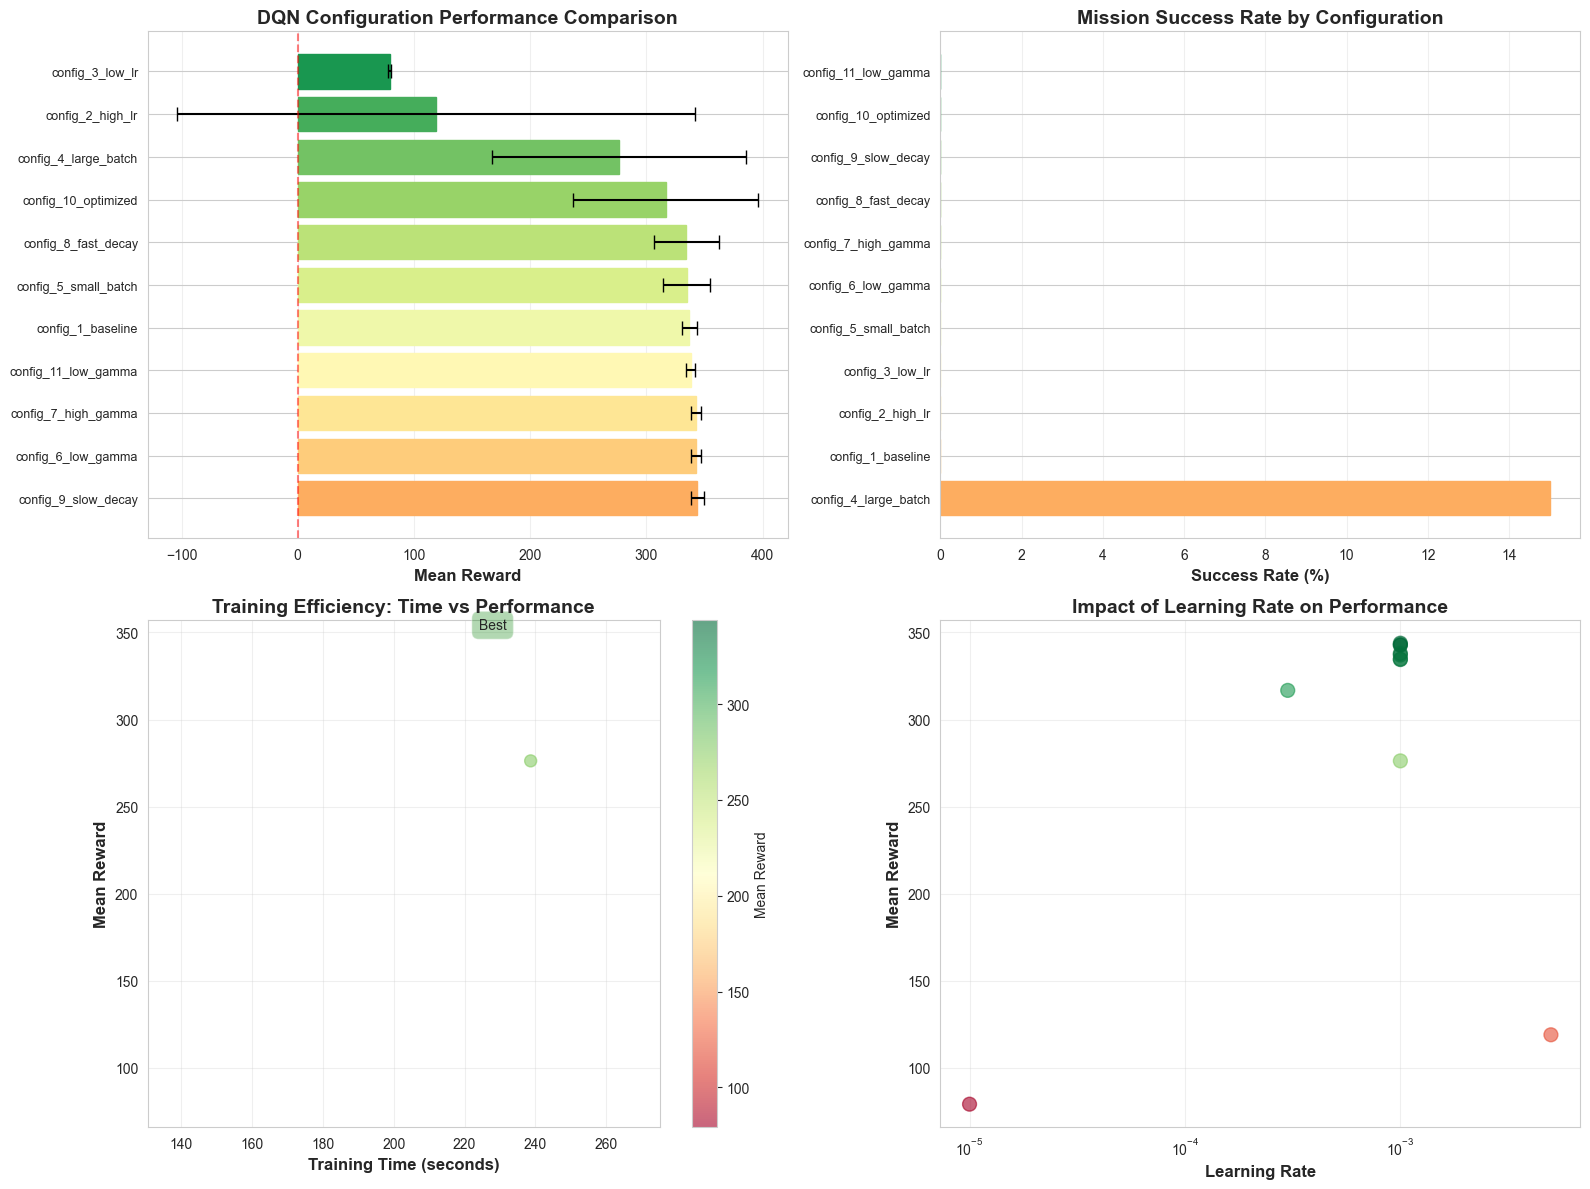

In [9]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9: Visualize Results - Comparison Plot
# ═══════════════════════════════════════════════════════════════════════
"""
Create comprehensive visualization of results
"""

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort by mean reward
results_sorted = results_df.sort_values('mean_reward', ascending=False)

# 1. Mean Reward Comparison
ax1 = axes[0, 0]
bars = ax1.barh(range(len(results_sorted)), results_sorted['mean_reward'], 
                xerr=results_sorted['std_reward'], capsize=5)
ax1.set_yticks(range(len(results_sorted)))
ax1.set_yticklabels(results_sorted['config_name'], fontsize=9)
ax1.set_xlabel('Mean Reward', fontsize=12, fontweight='bold')
ax1.set_title('DQN Configuration Performance Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Color bars by performance
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax1.grid(axis='x', alpha=0.3)

# 2. Success Rate
ax2 = axes[0, 1]
success_sorted = results_df.sort_values('success_rate', ascending=False)
bars2 = ax2.barh(range(len(success_sorted)), success_sorted['success_rate'] * 100)
ax2.set_yticks(range(len(success_sorted)))
ax2.set_yticklabels(success_sorted['config_name'], fontsize=9)
ax2.set_xlabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Mission Success Rate by Configuration', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Color bars
colors2 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars2)))
for bar, color in zip(bars2, colors2):
    bar.set_color(color)

# 3. Training Time vs Performance
ax3 = axes[1, 0]
scatter = ax3.scatter(results_df['training_time'], results_df['mean_reward'], 
                     s=results_df['success_rate']*500, alpha=0.6, 
                     c=results_df['mean_reward'], cmap='RdYlGn')
ax3.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
ax3.set_title('Training Efficiency: Time vs Performance', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

# Add labels for best and worst
best_idx = results_df['mean_reward'].idxmax()
worst_idx = results_df['mean_reward'].idxmin()
ax3.annotate('Best', xy=(results_df.loc[best_idx, 'training_time'], 
                         results_df.loc[best_idx, 'mean_reward']),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Colorbar
plt.colorbar(scatter, ax=ax3, label='Mean Reward')

# 4. Hyperparameter Impact - Learning Rate
ax4 = axes[1, 1]
lr_values = []
rewards = []
for _, row in results_df.iterrows():
    if 'hyperparameters' in row and row['hyperparameters']:
        lr = row['hyperparameters'].get('learning_rate', None)
        if lr:
            lr_values.append(lr)
            rewards.append(row['mean_reward'])

if lr_values:
    ax4.scatter(lr_values, rewards, s=100, alpha=0.6, c=rewards, cmap='RdYlGn')
    ax4.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    ax4.set_title('Impact of Learning Rate on Performance', fontsize=14, fontweight='bold')
    ax4.set_xscale('log')
    ax4.grid(alpha=0.3)

plt.tight_layout()
plot_path = plots_dir / "dqn_comparison.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison plot saved to {plot_path}")
plt.show()

In [10]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 10: Detailed Analysis - Top 3 Configurations
# ═══════════════════════════════════════════════════════════════════════
"""
Detailed analysis of top 3 performing configurations
"""

print("\n" + "="*70)
print("TOP 3 CONFIGURATIONS - DETAILED ANALYSIS")
print("="*70)

top3 = results_df.nlargest(3, 'mean_reward')

for idx, (_, config) in enumerate(top3.iterrows(), 1):
    print(f"\n{'─'*70}")
    print(f"#{idx}: {config['config_name']}")
    print(f"{'─'*70}")
    print(f"Description: {config['description']}")
    print(f"Mean Reward: {config['mean_reward']:.2f} ± {config['std_reward']:.2f}")
    print(f"Success Rate: {config['success_rate']*100:.1f}%")
    print(f"Avg Episode Length: {config['mean_episode_length']:.1f} ± {config['std_episode_length']:.1f} steps")
    print(f"Training Time: {config['training_time']:.1f} seconds")
    
    if 'hyperparameters' in config and config['hyperparameters']:
        print(f"\nKey Hyperparameters:")
        hparams = config['hyperparameters']
        print(f"  - Learning Rate: {hparams.get('learning_rate', 'N/A')}")
        print(f"  - Batch Size: {hparams.get('batch_size', 'N/A')}")
        print(f"  - Buffer Size: {hparams.get('buffer_size', 'N/A')}")
        print(f"  - Gamma: {hparams.get('gamma', 'N/A')}")
        print(f"  - Exploration Fraction: {hparams.get('exploration_fraction', 'N/A')}")


TOP 3 CONFIGURATIONS - DETAILED ANALYSIS

──────────────────────────────────────────────────────────────────────
#1: config_9_slow_decay
──────────────────────────────────────────────────────────────────────
Description: Slow Decay - Extended exploration
Mean Reward: 343.86 ± 5.62
Success Rate: 0.0%
Avg Episode Length: 180.0 ± 0.0 steps
Training Time: 220.1 seconds

Key Hyperparameters:
  - Learning Rate: 0.001
  - Batch Size: 32
  - Buffer Size: 50000
  - Gamma: 0.99
  - Exploration Fraction: 0.4

──────────────────────────────────────────────────────────────────────
#2: config_6_low_gamma
──────────────────────────────────────────────────────────────────────
Description: Low Gamma - Myopic policy
Mean Reward: 342.96 ± 4.48
Success Rate: 0.0%
Avg Episode Length: 180.0 ± 0.0 steps
Training Time: 268.5 seconds

Key Hyperparameters:
  - Learning Rate: 0.001
  - Batch Size: 32
  - Buffer Size: 50000
  - Gamma: 0.95
  - Exploration Fraction: 0.2

──────────────────────────────────────────

In [11]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 11: Export Summary for Report
# ═══════════════════════════════════════════════════════════════════════
"""
Create summary tables and statistics for the final report
"""

# Summary statistics
summary = {
    'total_configs': len(all_results),
    'best_config': best_config['config_name'],
    'best_mean_reward': float(best_config['mean_reward']),
    'best_success_rate': float(best_config['success_rate']),
    'avg_mean_reward': float(results_df['mean_reward'].mean()),
    'std_mean_reward': float(results_df['mean_reward'].std()),
    'avg_success_rate': float(results_df['success_rate'].mean()),
    'total_training_time': float(results_df['training_time'].sum()),
}

# Save summary
summary_path = results_dir / "dqn_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)

print("\n" + "="*70)
print("DQN TRAINING SUMMARY")
print("="*70)
for key, value in summary.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

print(f"\n✓ Summary saved to {summary_path}")


DQN TRAINING SUMMARY
Total Configs: 11
Best Config: config_9_slow_decay
Best Mean Reward: 343.86
Best Success Rate: 0.0
Avg Mean Reward: 287.72622727272733
Std Mean Reward: 95.66483301907856
Avg Success Rate: 0.013636363636363636
Total Training Time: 2488.691916

✓ Summary saved to c:\Users\HP\Programming\ML\fire_rescue_agent\results\dqn_summary.json


In [12]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 12: Instructions for Next Steps
# ═══════════════════════════════════════════════════════════════════════
"""
Next steps after DQN training
"""

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("\n1. ✓ DQN Training Complete!")
print(f"   - Trained {len(all_results)} configurations")
print(f"   - Best model: {best_config['config_name']}")
print(f"   - Success rate: {best_config['success_rate']*100:.1f}%")

print("\n2. → Train Other Algorithms:")
print("   - PPO (Policy Gradient)")
print("   - A2C (Actor-Critic)")
print("   - REINFORCE")

print("\n3. → Compare All Algorithms:")
print("   - Create comparison plots")
print("   - Analyze which works best")
print("   - Write discussion section")

print("\n4. → Create Demonstration:")
print("   - Record video with best model")
print("   - Show Unity visualization")
print("   - Explain agent behavior")

print("\n5. → Files Generated:")
print(f"   - Models: {base_dir}")
print(f"   - Results: {csv_path}")
print(f"   - Plots: {plot_path}")
print(f"   - Summary: {summary_path}")

print("\n" + "="*70)
print("Ready to train PPO next? 🚀")
print("="*70)


NEXT STEPS

1. ✓ DQN Training Complete!
   - Trained 11 configurations
   - Best model: config_9_slow_decay
   - Success rate: 0.0%

2. → Train Other Algorithms:
   - PPO (Policy Gradient)
   - A2C (Actor-Critic)
   - REINFORCE

3. → Compare All Algorithms:
   - Create comparison plots
   - Analyze which works best
   - Write discussion section

4. → Create Demonstration:
   - Record video with best model
   - Show Unity visualization
   - Explain agent behavior

5. → Files Generated:
   - Models: c:\Users\HP\Programming\ML\fire_rescue_agent\models\dqn
   - Results: c:\Users\HP\Programming\ML\fire_rescue_agent\results\dqn_results.csv
   - Plots: c:\Users\HP\Programming\ML\fire_rescue_agent\results\plots\dqn_comparison.png
   - Summary: c:\Users\HP\Programming\ML\fire_rescue_agent\results\dqn_summary.json

Ready to train PPO next? 🚀
